load data

In [18]:
import os
import json
import numpy as np
from sympy import *

class BBOX():
    def __init__(self,x1,y1,x2,y2):
        for i in [x1,y1,x2,y2]:
            assert isinstance(i, float), 'float is not match'
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        
    def clip_by_shape(self, shape):
        self.x1 = np.clip(self.x1, 0, shape[1])
        self.x2 = np.clip(self.x2, 0, shape[1])
        self.y1 = np.clip(self.y1, 0, shape[0])
        self.y2 = np.clip(self.y2, 0, shape[0])
        return np.array([[self.x1,self.y1,self.x2,self.y2]])

    def is_box(self):
        return self.w > 0 and self.h > 0

    def area(self):
        return self.w * self.h
    
    @property
    def w(self):
        return self.x2 - self.x1 + 1

    @property
    def h(self):
        return self.y2 - self.y1 + 1

def solve_equ(ori, obj):
    sx = Symbol('sx')
    sy = Symbol('sy')
    dx = Symbol('dx')
    dy = Symbol('dy')
    x1,y1,x2,y2 = obj
    x11,y11,x22,y22 = ori
    out = solve([sx*x1 + dx - x11, sy*y1 + dy - y11, sx*x2 + dx - x22, sy*y2 + dy - y22 ], [sx,sy,dx,dy])
    return out

def load(head_addr, full_addr):
    with open(head_addr, 'rb') as f:
        head = json.load(f)
        annotations = np.array(head['annotations'])
        categories = np.array(head['categories'])
        images = np.array(head['images'])
    with open(full_addr, 'rb') as f:
        body = json.load(f)
        annotations_f = np.array(body['annotations'])
        categories_f = np.array(body['categories'])
        images_f = np.array(body['images'])
    headimg = processann(annotations, categories, images)
    fullimg = processann(annotations_f, categories_f, images_f)
#     head_match = sorted(headimg, key= lambda x : x['match_id'])
#     full_match = sorted(fullimg, key= lambda x : x['match_id'])
    print('finish head,full annotation making...')
    mean_xy = np.array([0,0,0,0,0])
    for i,hf in enumerate(zip(headimg, fullimg)):
        h = hf[0]
        f = hf[1]
        assert h['match_id'].all() == f['match_id'].all(), 'match_id is fail'
        assert h['id'] == f['id'], 'img is not match'
        outs = []
        for hb,fb in zip(h['bbox'],f['bbox']):
            out = solve_equ(fb, hb)
            if len(out) ==0:
                continue
            outs.append(out)
            name = list(out)
            mean_xy = mean_xy + [out[name[0]], out[name[1]],out[name[2]],out[name[3]], 1]
        headimg[i]['match_d'] = np.array(outs)
        print(mean_xy / mean_xy[-1], mean_xy[-1])
        if i%100 ==0:
            print('finish {} ...'.format(i))
        
    return headimg
    
    
    
    
    
        
def processann(annotations, categories, images):      
    imgtoann = []
    idtoanno = np.array([i['image_id'] for i in annotations])
    image = []
    for ids in images:
        inf = {}
        inf['id'] = ids['id']
        inf['file_name'] = '/home/yc/tensorpack_modify/examples/FasterRCNN/COCO/train2014/'+ ids['file_name']
        inf['height'] = ids['height']
        inf['width'] = ids['width']
        anno = np.where(idtoanno == inf['id'])
        anns = annotations[anno]
        for obj in anns:
            if obj['ignore'] == 1 or obj['area'] <=1:
                continue
            x1, y1, w, h = obj['bbox']
                
            box = [float(x1), float(y1),float(x1 + w), float(y1 + h)]
            cbox = BBOX(*box)
            box = cbox.clip_by_shape([inf['height'], inf['width']])
            if not cbox.is_box() or cbox.area() <4:
                continue
            
            if 'bbox' in inf.keys():
                inf['bbox'] = np.concatenate((inf['bbox'], box), axis = 0)
                inf['iscrowd'].append(obj['iscrowd'])
                inf['class'].append(1)
                inf['match_id'].append(obj['id'])
            else:
                inf['bbox'] = box
                inf['iscrowd'] = [obj['iscrowd']]
                inf['class'] = [1]
                inf['match_id'] = [obj['id']]
        try:
            assert 'bbox' in inf.keys(), 'no gt box in '+ inf['filename']
        except:
            continue
            
        inf['bbox'] = np.array(inf['bbox'])
        inf['iscrowd'] = np.array(inf['iscrowd'])
        inf['class'] = np.array(inf['class'])
        inf['match_id'] = np.array(inf['match_id'])
        image.append(inf)
    return np.array(image)
        
        

In [19]:
addrh = './instances_train_head2014.json'
addrf = './instances_train_visible2014.json'
# with open('./list.json', 'wb') as f:
#     lout = load(addrh, addrf)
#     json.dump(lout,f)

In [20]:
lout = load(addrh, addrf)

finish head,full annotation making...
[2.34981086721600 6.11156530835440 -606.172203247058 -538.495204362701 1.0] 7
finish 0 ...
[2.49175713362913 6.75885316188130 -474.126699184313 -1005.69309656760 1.0] 13
[2.51455950725305 6.62677809503144 -757.257145736522 -1265.25708960685 1.0] 27
[2.36667747394987 5.70218805311804 -695.663577142975 -1168.18718879799 1.0] 58
[2.45543065681224 5.75856174099011 -658.099427806548 -1177.62077128500 1.0] 73
[2.35836599345933 5.45719460741279 -794.305169216760 -1506.48725786396 1.0] 102
[2.33767029067339 4.75853642340103 -678.949261245584 -1316.42603352127 1.0] 168
[2.36509389584689 4.79325479086969 -701.941726177261 -1275.12282448684 1.0] 175
[2.42835786424957 4.28841097139076 -631.896473170525 -978.631661097454 1.0] 278
[2.43561891009517 4.31662043670431 -650.977819468269 -986.895027640807 1.0] 284
[2.43728341414069 4.32031457842753 -655.515131738236 -985.964687923709 1.0] 289
[2.40647169312550 4.48322298513034 -677.784228698619 -999.073209942832 1.0]

[2.54869098942058 5.14086587747413 -912.339380487570 -1561.76433581213 1.0] 2078
[2.55108407223142 5.15108944174652 -911.346249897786 -1558.56961485900 1.0] 2095
[2.55051244463595 5.13993233977952 -912.033733069229 -1553.51370785062 1.0] 2108
[2.53970115379321 5.10300235474105 -912.716968810056 -1544.22063546524 1.0] 2141
[2.54511115170365 5.11069720705301 -911.823585859442 -1542.47718828963 1.0] 2146
[2.54495338096580 5.10544858650650 -910.916048405569 -1537.12435451458 1.0] 2172
[2.54439600219572 5.11099086503022 -908.935309182812 -1533.45591642565 1.0] 2182
[2.54553592635911 5.11291768832431 -909.545650413530 -1534.26361018310 1.0] 2186
[2.54620759451752 5.11587499240820 -908.485509737377 -1534.44529428887 1.0] 2194
[2.54143534905593 5.10830680722250 -900.664104385288 -1540.95263215867 1.0] 2297
[2.54817081710269 5.12489994209428 -900.892833048488 -1533.95405202686 1.0] 2327
[2.55121535934342 5.13596977711752 -899.595620592131 -1537.84622694621 1.0] 2342
[2.54882324363298 5.14219943

[2.53595764120580 5.08825969945004 -911.240651475301 -1552.36906906806 1.0] 4055
[2.53626130691312 5.09072641648433 -910.887549740752 -1550.42545281535 1.0] 4061
[2.53738364417865 5.09565661706070 -910.814776063206 -1552.95911623529 1.0] 4075
[2.53744060159729 5.09795939186450 -911.833144239491 -1562.28547917988 1.0] 4090
[2.53782303850691 5.10469445735054 -910.754802813995 -1558.99040908072 1.0] 4116
[2.53763617159925 5.10170323556627 -909.981927822066 -1555.11070651862 1.0] 4128
[2.53723889271332 5.09822128490312 -909.047465554580 -1552.41464708877 1.0] 4137
[2.54069875688496 5.10033470715107 -923.364465666593 -1556.11332054706 1.0] 4144
[2.53948686031292 5.10709047669658 -921.472178014425 -1555.81767731494 1.0] 4157
[2.53889481536270 5.11378937262977 -920.393408810713 -1557.64043152056 1.0] 4171
[2.53809548636830 5.12706436702372 -919.062689741863 -1566.52396903428 1.0] 4200
[2.53760521870603 5.12234528139747 -917.965839439223 -1566.20918789219 1.0] 4220
[2.53856382806682 5.12498524

[2.54509727912052 5.04770239347561 -1019.33281558874 -1790.60088579748 1.0] 6609
[2.54629747987485 5.05225179701918 -1014.99583995249 -1785.38727990506 1.0] 6664
[2.54646032406661 5.06259798156523 -1016.12413604357 -1801.96771706629 1.0] 6723
[2.54581713460576 5.06882351486530 -1016.22166190146 -1812.20814293951 1.0] 6817
[2.54523045761318 5.06753920582039 -1014.19504586887 -1809.69030901184 1.0] 6846
[2.54500736439724 5.06859138406219 -1013.79679168512 -1808.85765149905 1.0] 6870
[2.54498915259810 5.06835231595098 -1013.06026221339 -1808.27367610255 1.0] 6881
[2.54692887369241 5.06989388318943 -1013.69973888868 -1806.76517211076 1.0] 6902
[2.54728979464188 5.07375032303091 -1015.83205184220 -1829.97631855364 1.0] 6919
[2.54751583514393 5.07452053569695 -1015.49529949046 -1830.31837379352 1.0] 6922
[2.54692873121736 5.07358241415983 -1016.31696018607 -1830.52654293902 1.0] 6933
[2.54755918793328 5.07720700685406 -1015.87278875544 -1830.24096675886 1.0] 6945
[2.54731584364407 5.07860153

[2.54725211077541 5.04326947925457 -1031.57239649220 -1867.90716822579 1.0] 8867
[2.54702106790399 5.04539941379071 -1030.80232796129 -1867.93612421915 1.0] 8884
[2.54699964986805 5.04916001311110 -1030.70357773821 -1870.28266100215 1.0] 8917
[2.54683164058838 5.05273974499148 -1029.77232926373 -1867.62314732984 1.0] 8933
[2.54708742946718 5.05258901418325 -1029.90460517105 -1865.77236574066 1.0] 8954
[2.54743058358148 5.05557954420992 -1029.31245556165 -1863.34594538948 1.0] 8967
[2.54768190350598 5.05642066620473 -1028.31322780457 -1861.47436213753 1.0] 8983
[2.54892786762502 5.05715818577558 -1028.30137135616 -1859.54855747948 1.0] 9006
[2.54829450430996 5.05265048176417 -1027.94135476817 -1856.21529374850 1.0] 9024
[2.54883431143098 5.05373513509689 -1028.68888830476 -1856.26216947272 1.0] 9034
[2.54977059881490 5.05352985585019 -1029.57010712437 -1854.49828747172 1.0] 9048
[2.54973955107749 5.05254229453313 -1029.39044156671 -1853.64667065192 1.0] 9053
[2.54951400537071 5.05100674

[2.55721534219806 5.10797315001118 -1043.35461395038 -1950.20158859963 1.0] 10852
[2.55775872233973 5.10977691263088 -1044.00316147563 -1952.66794466979 1.0] 10871
[2.55907617593005 5.10956040822055 -1043.23536413075 -1949.65999416841 1.0] 10915
[2.55900549052692 5.10955003385539 -1042.94555619078 -1948.85787409610 1.0] 10924
[2.55887981268272 5.10885164802387 -1043.58070305562 -1948.43885932146 1.0] 10929
[2.56071991125987 5.10807762323958 -1043.94126153001 -1942.86504268296 1.0] 10972
[2.56093128820186 5.11056777694003 -1045.19161555270 -1941.71780977494 1.0] 10993
[2.56192489194488 5.11409619385882 -1053.08975149013 -1951.27839228448 1.0] 11015
[2.56154164625774 5.11431826545875 -1052.43063955931 -1949.39022298938 1.0] 11034
[2.56079273898874 5.11334466258742 -1052.33138628905 -1945.18867376182 1.0] 11075
[2.56071836718720 5.11387594860112 -1052.34256376334 -1944.67401119333 1.0] 11094
[2.56099422975545 5.11335999859809 -1052.63219254908 -1943.77162640796 1.0] 11100
[2.5616980374796

[2.56598158911550 5.14184580685434 -1089.52762752912 -2003.51226185588 1.0] 13275
[2.56818300129372 5.13958798645782 -1087.91954898218 -1998.00229024227 1.0] 13319
[2.56835536467684 5.13986653481186 -1088.15389834331 -1998.04200823644 1.0] 13322
[2.56794606365396 5.14036972198144 -1087.51114391812 -1996.00575192647 1.0] 13341
[2.56765849921762 5.14050986724426 -1086.66925468144 -1994.19546559521 1.0] 13360
[2.56920538083932 5.14396325911353 -1090.19908604232 -1998.49474401721 1.0] 13392
[2.56892800889399 5.14625897362230 -1089.44370148566 -1996.01350595869 1.0] 13414
[2.56897000504364 5.14596897146404 -1089.43024742743 -1995.57612385159 1.0] 13418
[2.56895004921733 5.14732194901892 -1088.81511244934 -1995.49154073328 1.0] 13432
[2.56869246497136 5.14806259977082 -1088.58077273397 -1995.16368311763 1.0] 13453
[2.56716862247648 5.14009261635610 -1105.11963099819 -2034.36419136247 1.0] 13538
[2.56697205576910 5.14101475142283 -1104.45932469350 -2035.76328556960 1.0] 13553
[2.5677070873264

[2.56559638710060 5.10630618105979 -1118.13200603269 -2074.79960091804 1.0] 16089
[2.56584345399080 5.10744030623569 -1117.67805094912 -2073.62700771376 1.0] 16111
[2.56553331955622 5.10913704185206 -1116.77102019224 -2073.80519159581 1.0] 16142
[2.56526667620902 5.10985331100117 -1116.48436554554 -2074.61537083102 1.0] 16170
[2.56532122133251 5.11290157426963 -1116.42824106654 -2074.51205063551 1.0] 16189
[2.56538913518525 5.11348823418988 -1116.10144816306 -2074.07368242477 1.0] 16201
[2.56532855913753 5.11608734630215 -1115.07966473753 -2072.96611819791 1.0] 16232
[2.56554732834707 5.11782076833634 -1115.12038768651 -2073.25969503700 1.0] 16259
[2.56536017098282 5.11861586788982 -1114.79572356665 -2072.81243406518 1.0] 16269
[2.56501826174137 5.12113569221016 -1115.52536924533 -2083.27681426117 1.0] 16310
[2.56486550471514 5.12132926954284 -1115.30001247723 -2082.64873715926 1.0] 16317
[2.56509560206114 5.12037128086998 -1115.05419919631 -2081.90617662567 1.0] 16335
[2.5653132528724

[2.56778704133649 5.13031599137014 -1108.33370437931 -2065.45015000103 1.0] 18119
[2.56803452599695 5.13137429683098 -1108.15524203545 -2064.46019779567 1.0] 18132
[2.56807553937625 5.12998833908414 -1107.81389671234 -2063.59623915400 1.0] 18142
[2.56518911689625 5.12429585791818 -1108.06001946015 -2069.06626985472 1.0] 18259
[2.56545343306177 5.12535778855359 -1107.79597092235 -2068.90696335711 1.0] 18271
[2.56562135843673 5.12603805446873 -1108.85832484329 -2069.75160187406 1.0] 18279
[2.56565470126343 5.12633319335900 -1108.73240981597 -2069.30332123272 1.0] 18284
[2.56555811655539 5.12575451955637 -1108.77153800911 -2068.79417549498 1.0] 18291
[2.56617937487879 5.12429497751783 -1113.66064757494 -2070.32542960287 1.0] 18331
[2.56666382233820 5.12490464655212 -1114.35104751128 -2070.44380804624 1.0] 18336
[2.56690894436031 5.12477859373630 -1114.42420879078 -2070.25584048196 1.0] 18338
[2.56707575498278 5.12451058203873 -1114.31944041866 -2069.83681318184 1.0] 18342
[2.5673426540401

[2.57282961007698 5.14583394493687 -1106.11515701758 -2078.74418765871 1.0] 20503
[2.57315660666449 5.14703129677345 -1105.62974107851 -2078.62485339676 1.0] 20526
[2.57294354816876 5.14743581321964 -1105.95999896573 -2079.36421453220 1.0] 20538
[2.57307071595302 5.14786942875163 -1105.89659071005 -2079.93060321180 1.0] 20562
[2.57226542808703 5.14412086053511 -1105.17015604744 -2077.38548898410 1.0] 20597
[2.57229873369248 5.14474616752050 -1104.85740316054 -2076.65800820131 1.0] 20610
[2.57217663264672 5.14443065519260 -1104.73410592838 -2076.60105610041 1.0] 20614
[2.57224577677320 5.14496917920862 -1104.53259123098 -2076.00529653182 1.0] 20621
[2.57301387615122 5.14576417444598 -1105.28362748470 -2076.32172187361 1.0] 20716
[2.57309700341374 5.14621562531205 -1105.73933397814 -2077.80751855800 1.0] 20773
[2.57318765056992 5.14680362722551 -1105.65943268759 -2077.50128364730 1.0] 20778
[2.57271793792177 5.14581144902232 -1103.93034957360 -2074.01179375690 1.0] 20838
[2.5726604789662

[2.57117175678946 5.12229709612852 -1100.16738595780 -2075.47325183288 1.0] 23106
[2.57101212434052 5.12246712689405 -1099.93421381366 -2075.27050933238 1.0] 23114
[2.57073551187407 5.12073429568398 -1099.65577641380 -2074.28915856239 1.0] 23129
[2.57097720915251 5.12090087470000 -1099.68078893564 -2073.86914275179 1.0] 23136
[2.57124088861955 5.12337304283993 -1100.05707997804 -2076.41954895955 1.0] 23161
[2.57158408439249 5.12343634749864 -1100.05155972105 -2076.31831841298 1.0] 23163
[2.57158140588782 5.12304040496956 -1099.78063028306 -2075.35414445929 1.0] 23179
[2.57166056020028 5.12318885549469 -1098.98913170634 -2073.50639444427 1.0] 23204
[2.57154563841067 5.12339275748970 -1099.02117838685 -2073.64323191551 1.0] 23226
[2.57143442371753 5.12351807216764 -1098.46169661510 -2071.69047088049 1.0] 23256
[2.57227380865568 5.12359423065550 -1097.22585337402 -2067.99516292480 1.0] 23350
[2.57234947758208 5.12418957407173 -1097.06625273891 -2069.16901401641 1.0] 23366
[2.5722739052481

[2.58129671468640 5.12222967935963 -1102.36278543316 -2033.60946929539 1.0] 25558
[2.58155951298696 5.12372306294156 -1101.95918869808 -2033.00861752823 1.0] 25583
[2.58162638585977 5.12361024710679 -1101.92025702087 -2032.39114200891 1.0] 25592
[2.58140167814562 5.12346349341390 -1104.74617954312 -2033.30322130465 1.0] 25614
[2.58155440365355 5.12502396646865 -1104.56320355122 -2034.23332035177 1.0] 25643
[2.58317613060711 5.13026797204521 -1103.81295719960 -2051.02545497152 1.0] 25812
[2.58312939173433 5.12949400445741 -1103.95609300906 -2050.88998349492 1.0] 25822
[2.58252017543459 5.12795728568284 -1103.13339787882 -2049.58303817798 1.0] 25853
[2.58225436936159 5.12725440044758 -1103.11896888550 -2049.69786912775 1.0] 25862
[2.58224554160216 5.12790635703873 -1102.79707154138 -2048.65489252164 1.0] 25896
[2.58444873915927 5.13254341471122 -1118.75652394925 -2092.95256369568 1.0] 26086
[2.58407405794301 5.13297561855786 -1118.55873816151 -2092.39661768360 1.0] 26109
[2.5844316724215

[2.58574365395105 5.14439757782687 -1124.89011419746 -2126.36306687504 1.0] 28098
[2.58631365499515 5.14395869113880 -1125.64137872699 -2126.29809252829 1.0] 28112
[2.58646556575543 5.14471338127633 -1125.50001041782 -2125.96590422479 1.0] 28128
[2.58645777491750 5.14518624043319 -1125.59614956959 -2125.17729255497 1.0] 28143
[2.58654194930043 5.14547098400560 -1125.48682860136 -2124.92514950393 1.0] 28148
[2.58644494577803 5.14575869078298 -1125.21371751482 -2123.79730470290 1.0] 28169
[2.58643869838686 5.14582599368164 -1125.15088416424 -2123.67720110426 1.0] 28172
[2.58634552059688 5.14655121733819 -1124.96293375254 -2123.30275986121 1.0] 28183
[2.58652194919051 5.14588356240808 -1126.02612824390 -2123.31324816304 1.0] 28197
[2.58661437195431 5.14682375973829 -1125.94675961351 -2123.29915637158 1.0] 28221
[2.58644577641272 5.14692101073740 -1125.96668123950 -2123.14492217595 1.0] 28237
[2.58661691043665 5.14818271415326 -1125.42008076188 -2122.77817302518 1.0] 28267
[2.5864897129201

[2.58283280535182 5.13573735904293 -1127.19990784367 -2119.65878708854 1.0] 30059
[2.58282405306379 5.13540210228546 -1127.20210622760 -2119.46662042023 1.0] 30063
[2.58287128594472 5.13518654683633 -1126.89381551906 -2118.69001570347 1.0] 30078
[2.58292795370172 5.13501028078771 -1126.87633939358 -2118.46045127518 1.0] 30082
[2.58262297517049 5.13502845369877 -1126.31632416638 -2117.94840064761 1.0] 30100
[2.58291103108270 5.13565076587197 -1126.48978205694 -2117.92352622869 1.0] 30105
[2.58267736473137 5.13598670283828 -1126.85106079610 -2120.16546674744 1.0] 30125
[2.58270785578861 5.13606554555021 -1126.75508518596 -2120.16106619866 1.0] 30128
[2.58271521731118 5.13667900940049 -1126.68445251055 -2120.00344170887 1.0] 30145
[2.58279579654256 5.13652972551965 -1126.67330111615 -2119.78409175824 1.0] 30149
[2.58281640118289 5.13658356902977 -1126.44178454089 -2119.57054211535 1.0] 30157
[2.58267845820534 5.13727991974742 -1126.10780469631 -2119.02756179696 1.0] 30173
[2.5825012908656

[2.58628664838504 5.13847127880051 -1131.00291152094 -2106.43618230491 1.0] 32347
[2.58653533047752 5.13938315951659 -1130.57399452219 -2105.51250906902 1.0] 32386
[2.58660381709086 5.13876308164329 -1130.49719556071 -2104.48858217623 1.0] 32406
[2.58623234782795 5.13737699104437 -1130.09142139667 -2103.57863466893 1.0] 32424
[2.58612943830147 5.13633464329605 -1130.76765747155 -2106.04219154438 1.0] 32462
[2.58573015156423 5.13498196916357 -1130.33045516985 -2105.03486514295 1.0] 32481
[2.58573667129419 5.13482556395774 -1130.33330754191 -2104.43828884773 1.0] 32515
[2.58598540734057 5.13514360036728 -1130.24903605881 -2104.27209604559 1.0] 32535
[2.58600071796052 5.13495551501591 -1130.50488148290 -2104.67542143659 1.0] 32541
[2.58592758855275 5.13527255908702 -1130.33009823231 -2104.58384937725 1.0] 32553
[2.58589653212555 5.13525047986225 -1130.08670690617 -2104.05178165389 1.0] 32565
[2.58572596862037 5.13521903035061 -1129.93097053071 -2103.71785198707 1.0] 32577
[2.5857646082047

[2.59029435230084 5.14249330638456 -1140.34250861176 -2105.53437979393 1.0] 34258
[2.59017820329500 5.14216099833048 -1140.17375249630 -2105.04387054052 1.0] 34271
[2.59033229228360 5.14249875455350 -1139.97479965226 -2104.64645152218 1.0] 34282
[2.59032572189369 5.14268791394878 -1140.06483795907 -2104.61503231880 1.0] 34302
[2.59049191764508 5.14441989580723 -1139.75050742350 -2106.23982742812 1.0] 34330
[2.59049914504362 5.14453026100692 -1139.61293061396 -2105.85322549601 1.0] 34337
[2.59058867565502 5.14474173658836 -1139.56633468703 -2105.80289680108 1.0] 34344
[2.59039451812293 5.14515654143089 -1139.01538598728 -2104.98724350821 1.0] 34368
[2.59077228932062 5.14523071074955 -1139.25577707800 -2104.90029952921 1.0] 34373
[2.59053538674702 5.14415193315239 -1138.75634707919 -2103.61125150342 1.0] 34399
[2.59050864042488 5.14400634869919 -1138.88703839444 -2103.39519323088 1.0] 34404
[2.59078036121491 5.14421814406750 -1138.36031310695 -2102.12250212314 1.0] 34445
[2.5905901675833

[2.58983103144208 5.14160877674756 -1136.29227558714 -2093.29227447888 1.0] 36449
[2.59020757363899 5.14114462404497 -1136.11892048271 -2092.71008313400 1.0] 36462
[2.59029815605845 5.14124298785222 -1136.17671870297 -2092.72140919186 1.0] 36465
[2.59048203536074 5.14184043008333 -1136.77397162014 -2095.29325323397 1.0] 36482
[2.59043017318863 5.14187018727015 -1136.69684205827 -2095.13326305092 1.0] 36485
[2.59039790314015 5.14173475495664 -1136.63797672310 -2094.98898966078 1.0] 36488
[2.59053481369402 5.14181382413837 -1136.55621802676 -2094.83193590851 1.0] 36494
[2.59049298139236 5.14200351760816 -1136.43541244124 -2095.10299917370 1.0] 36505
[2.59059568079069 5.14193394233767 -1136.55233536503 -2094.88705134753 1.0] 36511
[2.59070617389357 5.14275544633292 -1136.31518388579 -2094.73908265430 1.0] 36531
[2.59086542170190 5.14244275782018 -1136.29813058331 -2094.40280790654 1.0] 36537
[2.59080654488357 5.14230391306220 -1136.06432418363 -2093.88441947247 1.0] 36551
[2.5906092986222

[2.58732268910385 5.13501024084534 -1149.31670708127 -2114.26168377466 1.0] 38675
[2.58733242697368 5.13469513201505 -1149.20727795264 -2113.45937444863 1.0] 38691
[2.58735063664588 5.13477312832765 -1149.18811486161 -2113.41880635392 1.0] 38693
[2.58737650047468 5.13547654070206 -1149.15300209267 -2112.71080752581 1.0] 38709
[2.58735607205163 5.13491619349068 -1149.69960817581 -2116.73464875693 1.0] 38765
[2.58711735970612 5.13471525045210 -1149.63637994912 -2115.96480250548 1.0] 38794
[2.58700295762285 5.13408132923896 -1149.37461578866 -2115.28633100690 1.0] 38808
[2.58710073494363 5.13443203253592 -1149.51212601234 -2115.29482692188 1.0] 38813
[2.58715040779782 5.13429502649778 -1149.51670814226 -2115.14334067425 1.0] 38817
[2.58706450218656 5.13499695003041 -1149.34270766200 -2114.66152322402 1.0] 38855
[2.58721934129372 5.13607474599802 -1149.22531344411 -2114.56548644991 1.0] 38885
[2.58738771671712 5.13708924685106 -1149.57414512533 -2115.89814960858 1.0] 38918
[2.5874523361855

[2.58276904904623 5.12195784296356 -1138.36675644466 -2087.82135461305 1.0] 40764
[2.58277314277067 5.12222645060842 -1138.33738532638 -2087.86905047703 1.0] 40769
[2.58283244418935 5.12271268173212 -1138.47597975149 -2088.25906453004 1.0] 40785
[2.58278881329887 5.12104827679487 -1137.98401115028 -2087.03235070212 1.0] 40827
[2.58284336352104 5.12114363833311 -1137.78678080361 -2087.12651974625 1.0] 40837
[2.58284298272158 5.12128612930747 -1137.70551968603 -2086.93189481476 1.0] 40842
[2.58279779594572 5.12075935842372 -1137.89377915353 -2086.60191530366 1.0] 40852
[2.58261870258456 5.12085532061425 -1137.61987784864 -2086.30412555048 1.0] 40867
[2.58266322716333 5.12130892370124 -1137.65320724292 -2086.30624642592 1.0] 40881
[2.58236562233896 5.12041061417517 -1137.43197867639 -2085.82030688768 1.0] 40895
[2.58283412012616 5.12303030462167 -1136.63801991016 -2085.81132408963 1.0] 40976
[2.58287475776347 5.12342158892660 -1136.61308244337 -2085.43155259594 1.0] 40985
[2.5827456179632

[2.58102835015289 5.11964037143803 -1128.24496293716 -2065.81837775904 1.0] 43174
[2.58107124724526 5.12087159636418 -1130.08006196469 -2075.36235384583 1.0] 43231
[2.58113783699915 5.12134142636767 -1129.98901631057 -2074.73477727725 1.0] 43260
[2.58080703659582 5.12045054029418 -1129.59590058910 -2073.80445732687 1.0] 43283
[2.58081193882638 5.12056003825615 -1131.06610917746 -2076.97323252682 1.0] 43319
[2.58096894127051 5.12129871789352 -1130.85664406656 -2076.36461210458 1.0] 43348
[2.58101329812847 5.12116034101379 -1130.85813999635 -2076.24277806795 1.0] 43351
[2.58102910025119 5.12187928457569 -1130.73735923955 -2075.86891955043 1.0] 43374
[2.58140860113247 5.12361516062499 -1136.67025365639 -2087.52724139603 1.0] 43468
[2.58146318392934 5.12394115168669 -1136.73547774843 -2087.61504413872 1.0] 43476
[2.58149930437124 5.12454070178266 -1136.39941947381 -2086.69340245288 1.0] 43511
[2.58212788866478 5.12465687294774 -1136.80929226157 -2086.61587179940 1.0] 43519
[2.5820541376408

[2.58120042982166 5.12485199757596 -1132.15927523758 -2082.30327874857 1.0] 45479
[2.58141199760396 5.12507537959504 -1132.17543141673 -2082.14845157070 1.0] 45486
[2.58135525945448 5.12539487451921 -1131.99186221436 -2082.12568491604 1.0] 45496
[2.58126424888580 5.12491343818785 -1131.89794211583 -2081.71689076221 1.0] 45506
[2.58127043213790 5.12466853458648 -1131.81797952260 -2081.46363074191 1.0] 45516
[2.58137814007033 5.12483610056365 -1131.90897366707 -2081.27115596869 1.0] 45523
[2.58148062744910 5.12486658474828 -1131.94501587668 -2081.06176286810 1.0] 45529
[2.58156426796985 5.12490146448170 -1131.98768564441 -2080.90568988529 1.0] 45534
[2.58104723804475 5.12475895516459 -1131.27555383805 -2079.87549840863 1.0] 45596
[2.58108665467682 5.12491769174548 -1131.29211866880 -2079.86005756937 1.0] 45602
[2.58099483001818 5.12485690771412 -1131.18808443483 -2079.57282659415 1.0] 45617
[2.58094478525396 5.12490984816067 -1131.25660563604 -2079.42422125524 1.0] 45623
[2.5809880089152

[2.58140296377317 5.12255826689108 -1130.76362646019 -2081.01512563910 1.0] 47779
[2.58133642976325 5.12222743389909 -1130.65055389661 -2080.73405130255 1.0] 47786
[2.58130801666558 5.12223124589665 -1130.67032558890 -2080.92891563772 1.0] 47790
[2.58102462528484 5.12195340193697 -1131.35915308443 -2081.58733456720 1.0] 47823
[2.58070376804047 5.12102273669882 -1132.22409675820 -2082.90522438903 1.0] 47858
[2.58078825567027 5.12108279776898 -1132.19029179163 -2082.77883858278 1.0] 47862
[2.58091284191398 5.12104098920163 -1132.14914946663 -2082.48056856115 1.0] 47870
[2.58103302052218 5.12179770349459 -1132.14082845712 -2082.51640679498 1.0] 47890
[2.58105623851132 5.12186955760188 -1132.16388618047 -2082.45218125508 1.0] 47894
[2.58121717104815 5.12213057949472 -1132.17335355865 -2082.41782422586 1.0] 47905
[2.58131454595694 5.12243856705910 -1132.12878290861 -2082.31751045937 1.0] 47918
[2.58141701383879 5.12249233867124 -1132.09726313068 -2081.96073062724 1.0] 47928
[2.5813990313453

[2.58398768649713 5.13073827356584 -1128.84953813371 -2065.13242334338 1.0] 49585
[2.58364844300979 5.12928528866568 -1128.48296115687 -2064.08622096947 1.0] 49614
[2.58363208429645 5.12908074060678 -1128.19725095614 -2064.27829698999 1.0] 49643
[2.58383773574631 5.13003604627055 -1128.09397932342 -2064.15679913233 1.0] 49666
[2.58400065400622 5.13004617859331 -1127.94972801681 -2063.88745846808 1.0] 49691
[2.58408393205958 5.13081588552732 -1127.99229566483 -2064.27639219861 1.0] 49709
[2.58359168597136 5.12885872823795 -1128.50119940012 -2064.15397207463 1.0] 49749
[2.58351517366841 5.12925596852795 -1128.21933292542 -2063.65431587482 1.0] 49772
[2.58337474076176 5.12923329152398 -1128.04844975773 -2063.26028457058 1.0] 49791
[2.58330014040965 5.12898995102146 -1128.05850798764 -2063.25511119032 1.0] 49798
[2.58332165680638 5.12918906624093 -1128.08197478111 -2063.25582727293 1.0] 49803
[2.58358922550628 5.12968725251475 -1129.62488509143 -2065.99713912133 1.0] 49816
[2.5834788224720

[2.58125064410197 5.12924306040583 -1130.76441134099 -2064.98413342408 1.0] 51682
[2.58113500524076 5.12970309580445 -1130.46706481940 -2064.83318645199 1.0] 51709
[2.58081006850127 5.12850396992785 -1129.96147900514 -2063.61629240208 1.0] 51747
[2.58064672665601 5.12891914361877 -1129.53642152325 -2063.14296168239 1.0] 51781
[2.58075855604492 5.12924615879960 -1129.44755089703 -2063.06501361316 1.0] 51793
[2.58080874197099 5.12888181605217 -1129.55449568262 -2064.05178790235 1.0] 51816
[2.58079649070161 5.12907336101360 -1129.47208099130 -2063.86142324527 1.0] 51823
[2.58081687006466 5.12925879954596 -1129.44172089132 -2063.77941151721 1.0] 51828
[2.58082474307607 5.12876477907587 -1129.36523279838 -2063.44180254996 1.0] 51838
[2.58065738023717 5.12936747592928 -1129.06334111355 -2062.96901968748 1.0] 51861
[2.58053956027258 5.12986123555266 -1129.05504879231 -2062.54535308497 1.0] 51873
[2.58067586031222 5.13023289043738 -1128.78912246425 -2063.12429912514 1.0] 51903
[2.5806003044230

[2.58279400127834 5.12470631616122 -1138.78541912539 -2079.26761850049 1.0] 54117
[2.58262804762524 5.12429699490442 -1138.57527003285 -2078.19015345471 1.0] 54146
[2.58268834304784 5.12467890812637 -1138.41269525576 -2077.60623604392 1.0] 54168
[2.58256768959750 5.12439206391236 -1138.06168157319 -2076.84299162527 1.0] 54209
[2.58322959626622 5.12447550240192 -1138.02766762819 -2075.66780971933 1.0] 54284
[2.58338192881263 5.12485609691310 -1138.11882168537 -2075.68868458300 1.0] 54295
[2.58335297546813 5.12444212850478 -1137.96386037449 -2075.31918186013 1.0] 54311
[2.58338405053053 5.12481633495752 -1137.83750244250 -2075.12208589076 1.0] 54323
[2.58345785505961 5.12444476126088 -1138.36963572358 -2075.43305547455 1.0] 54347
[2.58333695325006 5.12424864306992 -1138.36078123464 -2075.30892385791 1.0] 54363
[2.58332549618986 5.12504097328118 -1138.95423649437 -2076.25748169328 1.0] 54389
[2.58337522465629 5.12509243999935 -1138.90110015048 -2076.19051618238 1.0] 54394
[2.5834672278270

[2.59379645948738 5.12400453178509 -1139.29694395412 -2080.86402852981 1.0] 56776
[2.59352817850477 5.11995737860848 -1138.98988971043 -2077.50912695966 1.0] 56885
[2.59358614574187 5.12025893700887 -1138.81809970502 -2077.06833964184 1.0] 56913
[2.59317338612073 5.11995685449093 -1138.34758090094 -2076.33073511514 1.0] 57001
[2.59307153598680 5.12069274999591 -1138.17101204358 -2076.88264949338 1.0] 57032
[2.59300637016309 5.12096365947124 -1138.05447468094 -2077.12714158433 1.0] 57043
[2.59350492247918 5.12145580170615 -1138.04872410338 -2078.34810606266 1.0] 57053
[2.59357389814884 5.12151329887540 -1138.00824580867 -2078.46848995107 1.0] 57060
[2.59341742156610 5.12148465621836 -1137.87597153289 -2078.13308837881 1.0] 57077
[2.59337384263267 5.12123957695517 -1137.82018718881 -2077.99734178831 1.0] 57081
[2.59346224927861 5.12114292765145 -1137.75467917483 -2077.83522761340 1.0] 57090
[2.59343917664284 5.12106753911447 -1137.73089433599 -2077.71055107851 1.0] 57096
[2.5933747836741

[2.59030310997241 5.11642608425228 -1137.55512904339 -2065.91752449262 1.0] 59162
[2.59033623625702 5.11657368283506 -1137.45157742057 -2065.70607055128 1.0] 59171
[2.59027010383161 5.11671463941832 -1137.34041601080 -2065.28855311796 1.0] 59187
[2.59024609550528 5.11688936086829 -1137.27136277310 -2065.14566350712 1.0] 59194
[2.59043220033558 5.11742949057157 -1138.50909824909 -2065.24900674304 1.0] 59331
[2.59047945826785 5.11749000481492 -1138.51489404478 -2065.26887071480 1.0] 59347
[2.59048311839754 5.11772298465999 -1138.40528479364 -2065.11964665164 1.0] 59357
[2.59022257791430 5.11699952285813 -1138.09646947855 -2064.47459783306 1.0] 59379
[2.59017724415875 5.11683109254686 -1138.04841428563 -2064.36575958059 1.0] 59383
[2.59018552160831 5.11703684782247 -1137.99610623909 -2064.25719710773 1.0] 59390
[2.59017664005805 5.11718723803401 -1137.94888674526 -2064.12372348222 1.0] 59396
[2.59026742635457 5.11778172884258 -1137.86026847242 -2063.99192397817 1.0] 59415
[2.5903904075924

[2.58898575820826 5.11556655566534 -1136.50088016452 -2055.88032620584 1.0] 61571
[2.58846499378194 5.11385082332158 -1135.93401701820 -2054.67276166765 1.0] 61617
[2.58846279518180 5.11397630987561 -1135.83580130177 -2054.46537563820 1.0] 61626
[2.58849086842268 5.11411053567036 -1135.82171618085 -2054.42909208739 1.0] 61629
[2.58845289651176 5.11425250134798 -1135.77571847757 -2054.26143933137 1.0] 61636
[2.58840538031080 5.11451713081787 -1135.65990917740 -2054.10478142153 1.0] 61646
[2.58874054642478 5.11504772116280 -1135.90279287954 -2054.74324417750 1.0] 61714
[2.58858801407088 5.11497552964145 -1135.61329517587 -2054.14115171274 1.0] 61740
[2.58848110481739 5.11524782415951 -1135.40180367366 -2054.45333966242 1.0] 61794
[2.58850147245532 5.11527365645677 -1135.42873244110 -2054.33792587474 1.0] 61799
[2.58855718479688 5.11561622881446 -1135.37850512591 -2054.10108430443 1.0] 61809
[2.58860619221152 5.11594585969929 -1135.31265089765 -2053.97268452428 1.0] 61823
[2.5885746746374

[2.58824232795263 5.12246167581178 -1137.84452216007 -2058.35861946583 1.0] 63642
[2.58819257692499 5.12251504413692 -1137.77279750910 -2058.36697278838 1.0] 63650
[2.58827501155408 5.12242982049338 -1137.69784627997 -2058.13716101223 1.0] 63661
[2.58830277692649 5.12234729632106 -1137.66382962428 -2058.01823541859 1.0] 63665
[2.58833198983393 5.12291510199037 -1137.63156969367 -2058.05642180951 1.0] 63690
[2.58833836209370 5.12318061956699 -1137.57095447293 -2058.79596297658 1.0] 63703
[2.58832580913801 5.12346188117068 -1137.49007182506 -2058.44785623931 1.0] 63718
[2.58841661165240 5.12400202382251 -1138.05416919732 -2059.31821212473 1.0] 63735
[2.58833813897300 5.12359370832392 -1137.87689879306 -2058.83416028594 1.0] 63754
[2.58835303951652 5.12358916497937 -1137.85289421774 -2058.69185877487 1.0] 63759
[2.58838036734777 5.12368188291762 -1137.89630499500 -2058.50484853150 1.0] 63770
[2.58841239346588 5.12370503421705 -1137.76209796546 -2058.28582730503 1.0] 63783
[2.5886270152145

[2.58646157429620 5.11772879715922 -1137.75021042638 -2055.06889398569 1.0] 65923
[2.58644837453188 5.11783432005552 -1137.72061281293 -2054.81848431336 1.0] 65935
[2.58655672415434 5.11803421470083 -1137.74348011559 -2054.69275653301 1.0] 65943
[2.58648762465428 5.11762068483816 -1137.48581582384 -2054.07000703331 1.0] 65969
[2.58671375777174 5.11759271335694 -1137.57227848965 -2053.89348003060 1.0] 65980
[2.58671831470818 5.11729410545694 -1137.54205839323 -2053.49988383837 1.0] 66004
[2.58666647141688 5.11767747884276 -1137.25097242978 -2053.05167670807 1.0] 66044
[2.58648633727471 5.11708182027530 -1137.09437507015 -2052.71938220210 1.0] 66056
[2.58637952348707 5.11686719026918 -1136.89609858083 -2052.29715069991 1.0] 66076
[2.58636655352584 5.11678619263346 -1136.87064145875 -2052.21234715329 1.0] 66079
[2.58625604629045 5.11674780014302 -1137.11134248992 -2054.05441422532 1.0] 66110
[2.58612176166013 5.11626013326403 -1136.98649703222 -2053.63739772866 1.0] 66125
[2.5862545660389

[2.58670091188175 5.11383835865527 -1137.42187992866 -2043.99581843328 1.0] 68073
[2.58672588688356 5.11402971503793 -1137.30934097626 -2043.96197030297 1.0] 68087
[2.58662041760295 5.11478640794483 -1140.43882688710 -2050.07861003794 1.0] 68171
[2.58673701940496 5.11501868940701 -1140.49114111026 -2049.98095305874 1.0] 68191
[2.58654842741396 5.11490708178266 -1140.18917309697 -2049.44792891837 1.0] 68219
[2.58649214049959 5.11491271336455 -1140.09103655076 -2049.31267227595 1.0] 68233
[2.58681707835517 5.11484845532481 -1140.00074255728 -2049.91584647098 1.0] 68266
[2.58699790539620 5.11575043785138 -1140.01520271359 -2050.87977236093 1.0] 68298
[2.58705055738211 5.11581353202734 -1139.95059840124 -2050.68763892096 1.0] 68306
[2.58709084188192 5.11463877540626 -1139.52479850073 -2049.27431688662 1.0] 68366
[2.58714983105465 5.11466009701526 -1139.42807622855 -2048.85153921475 1.0] 68388
[2.58740568983036 5.11489943705624 -1142.15673636525 -2051.33126399508 1.0] 68413
[2.5873905334367

[2.58720896340877 5.11099668923643 -1140.04185663732 -2051.60738609602 1.0] 70512
[2.58723272769350 5.11100548872897 -1139.97139900309 -2051.44178363907 1.0] 70519
[2.58704753221435 5.10973316359245 -1139.68235662642 -2050.66882590496 1.0] 70550
[2.58701089190239 5.10968866172433 -1139.57146491661 -2050.66909330924 1.0] 70561
[2.58693263026954 5.10962156360835 -1139.44463402960 -2050.60526626148 1.0] 70589
[2.58709199335083 5.11062291955249 -1139.24571478669 -2050.23844710351 1.0] 70639
[2.58677980376506 5.10952665285844 -1139.23076380813 -2049.69998618179 1.0] 70678
[2.58669708803808 5.10938162592802 -1140.65099105713 -2050.88013730120 1.0] 70717
[2.58671722575314 5.10976866362206 -1140.39712803215 -2050.43265628035 1.0] 70751
[2.58667095931433 5.10956623849297 -1140.32904952345 -2050.23486553242 1.0] 70758
[2.58650725728255 5.10954123776736 -1139.98439273219 -2049.68734139123 1.0] 70793
[2.58657186691959 5.10990543726212 -1139.84931835917 -2049.51405672341 1.0] 70813
[2.5865107917309

[2.58694904176481 5.11255500371377 -1140.79195129637 -2051.72305932253 1.0] 72640
[2.58697508482449 5.11273833160404 -1140.72347599642 -2051.56180069205 1.0] 72649
[2.58659935020906 5.11057151759356 -1140.13693523735 -2050.35674060543 1.0] 72722
[2.58672941485613 5.11107293351957 -1140.06099119282 -2050.19473444720 1.0] 72744
[2.58677304387392 5.11126275108328 -1140.05484760586 -2049.93082086056 1.0] 72757
[2.58669712410327 5.11143165776830 -1139.90032580340 -2049.82840215350 1.0] 72782
[2.58679089851135 5.11162951443025 -1139.63081320023 -2049.10496588435 1.0] 72829
[2.58696110266339 5.11178735489498 -1139.63054444916 -2049.37210652290 1.0] 72855
[2.58686136308315 5.11169033721242 -1139.55865389998 -2049.22023014745 1.0] 72880
[2.58672777011686 5.11160667755469 -1139.58055656396 -2048.99566995641 1.0] 72903
[2.58664453466364 5.11129772254038 -1139.47201655701 -2048.36087711114 1.0] 72928
[2.58652104902551 5.11105202553834 -1139.42344958005 -2048.39410311718 1.0] 72956
[2.5864715326472

[2.58514488501266 5.09577378129380 -1139.53679987080 -2046.03035370430 1.0] 75117
[2.58522842326759 5.09599025764047 -1139.51551048188 -2045.97869578878 1.0] 75126
[2.58529198047981 5.09653546689158 -1139.51118812735 -2045.91231459341 1.0] 75155
[2.58540247496508 5.09596254235547 -1140.66873552372 -2047.14837256129 1.0] 75225
[2.58548736446412 5.09623870798030 -1140.66715636875 -2047.09163540363 1.0] 75234
[2.58548409550260 5.09624896380426 -1140.59724626266 -2046.86665899872 1.0] 75252
[2.58546931429287 5.09648831928071 -1140.47915063589 -2046.87793718606 1.0] 75284
[2.58547929586356 5.09666624547827 -1140.41487089598 -2046.89868834194 1.0] 75292
[2.58553648189825 5.09673684472123 -1140.58467962077 -2046.96013162912 1.0] 75297
[2.58554893856181 5.09679710793944 -1140.55178341178 -2046.93222668064 1.0] 75302
[2.58552504134523 5.09667179847723 -1140.52837460160 -2046.85394400098 1.0] 75305
[2.58567723023676 5.09655533387366 -1141.31345471750 -2046.48069673389 1.0] 75348
[2.5856732523859

[2.58520532170441 5.09236342391701 -1139.64816218340 -2044.28562950157 1.0] 77295
[2.58519866020488 5.09266911190954 -1139.51366428900 -2044.30654669299 1.0] 77318
[2.58513758864572 5.09300031273206 -1139.30372558706 -2044.14421990758 1.0] 77342
[2.58510333781235 5.09288068404019 -1139.25249528964 -2044.00573961558 1.0] 77353
[2.58494567136805 5.09278194338072 -1138.75794496855 -2043.39393281921 1.0] 77427
[2.58489895356511 5.09256628131914 -1138.71396389290 -2043.11530401368 1.0] 77441
[2.58486336310061 5.09245271200245 -1138.67099733542 -2043.00007216784 1.0] 77449
[2.58476953153785 5.09273686763236 -1138.34560124272 -2042.49561331138 1.0] 77485
[2.58477123567194 5.09274703979640 -1138.34518856812 -2042.49961885030 1.0] 77487
[2.58478115053138 5.09307067075677 -1138.22631930487 -2042.26209062023 1.0] 77514
[2.58488402997611 5.09273638335122 -1138.18988220488 -2042.07044728321 1.0] 77525
[2.58522946719184 5.09308846343321 -1138.38808144626 -2041.34264496424 1.0] 77576
[2.5852869458017

[2.58417433811428 5.09515954165410 -1134.43161352948 -2034.32817326268 1.0] 79489
[2.58440913269265 5.09538681570562 -1134.43748503396 -2034.13929804368 1.0] 79503
[2.58436390020191 5.09580804952504 -1134.51191302083 -2034.26559130418 1.0] 79525
[2.58431715777457 5.09575644390068 -1134.39101030950 -2034.05120589755 1.0] 79537
[2.58440508801598 5.09598796288746 -1134.56674397487 -2034.00864653396 1.0] 79547
[2.58445933663238 5.09605603516734 -1134.64786543827 -2033.86958006491 1.0] 79559
[2.58456432205472 5.09621601118609 -1134.76945024979 -2034.10158838813 1.0] 79569
[2.58459382409253 5.09616538351932 -1135.15825197325 -2035.01318256803 1.0] 79578
[2.58462963175452 5.09645449247347 -1135.11280302360 -2034.99433375391 1.0] 79596
[2.58460652670513 5.09716680131508 -1134.82434635512 -2034.85522918628 1.0] 79644
[2.58465551676733 5.09745493394839 -1134.77186673881 -2034.69933912694 1.0] 79664
[2.58439539854467 5.09636573710656 -1134.64754402156 -2033.90107687030 1.0] 79715
[2.5843853433591

[2.58502963911496 5.09537286070715 -1137.73274776286 -2041.97886514112 1.0] 82062
[2.58514034183677 5.09544378009927 -1137.83753276429 -2041.92990910492 1.0] 82073
[2.58506320867655 5.09522934702815 -1137.77688717006 -2041.76734157623 1.0] 82081
[2.58497481143825 5.09453955133547 -1137.47729508157 -2041.06598600224 1.0] 82115
[2.58495481710748 5.09478205458435 -1137.43499984018 -2041.06581758985 1.0] 82123
[2.58493296465187 5.09494437175191 -1137.37108275985 -2041.11218948782 1.0] 82131
[2.58489116316237 5.09517697008830 -1137.31598032064 -2040.87406073835 1.0] 82145
[2.58485418887564 5.09531330646205 -1137.20026406074 -2040.60923256243 1.0] 82160
[2.58486833068924 5.09527287187464 -1137.20756470683 -2040.51574021334 1.0] 82167
[2.58485621252737 5.09542395981648 -1137.24126578470 -2040.40869037874 1.0] 82174
[2.58484970309344 5.09566275032649 -1137.18918045056 -2040.33470506311 1.0] 82187
[2.58491031959581 5.09575110889760 -1137.16212574333 -2040.23632185798 1.0] 82197
[2.5849215165251

[2.58537169811395 5.09470520779334 -1138.46929002818 -2044.73629828699 1.0] 84363
[2.58516627976657 5.09397692488037 -1138.38003518999 -2044.31660334807 1.0] 84388
[2.58521007605738 5.09383059608252 -1138.35927564300 -2044.02827911728 1.0] 84401
[2.58521314925059 5.09375852885785 -1138.49731140018 -2043.95973580522 1.0] 84413
[2.58510262481062 5.09364246773393 -1138.27225598901 -2043.74621474342 1.0] 84455
[2.58510195117044 5.09355593581431 -1138.34122204203 -2043.72506013245 1.0] 84458
[2.58521258511115 5.09362364141059 -1138.31070572140 -2043.65815947278 1.0] 84464
[2.58524149275926 5.09374533566004 -1138.30958714288 -2043.59926454032 1.0] 84468
[2.58528173889015 5.09354637365930 -1138.65555454381 -2043.47598036433 1.0] 84500
[2.58556321163926 5.09364374067861 -1139.00440508386 -2043.42831707694 1.0] 84522
[2.58523495442850 5.09265073490571 -1138.63605270764 -2042.43030376469 1.0] 84577
[2.58464979632105 5.09095765628777 -1138.04888820074 -2041.36576236365 1.0] 84629
[2.5845944029229

[2.58546198714255 5.09381559780515 -1133.47760374574 -2034.84233957846 1.0] 86263
[2.58545232269440 5.09383013682067 -1133.43103778377 -2034.62082836912 1.0] 86275
[2.58541839800971 5.09373183345934 -1133.35665434449 -2034.43888459516 1.0] 86285
[2.58538694854084 5.09358537229224 -1133.30628343343 -2034.31265046614 1.0] 86292
[2.58527511376342 5.09300139645770 -1133.17210826575 -2033.97134477693 1.0] 86310
[2.58531495773811 5.09300273087785 -1133.15981829924 -2033.78505687787 1.0] 86319
[2.58539172752201 5.09289050882582 -1133.21321299476 -2033.67898011613 1.0] 86325
[2.58540190122566 5.09306548526571 -1133.19758939267 -2033.65535764417 1.0] 86332
[2.58520054305154 5.09271966139697 -1133.05940351568 -2033.44427918979 1.0] 86382
[2.58504201468332 5.09208415879700 -1132.91172530294 -2033.07822254658 1.0] 86403
[2.58508229121523 5.09229026505275 -1132.95236426491 -2033.12925140014 1.0] 86410
[2.58502140960214 5.09224455770299 -1132.84185597810 -2032.85178687342 1.0] 86425
[2.5849763447638

[2.58304296411049 5.08825511043520 -1130.12942727926 -2023.17340471741 1.0] 88685
[2.58309551071242 5.08819208472392 -1130.14502519189 -2022.98990827776 1.0] 88697
[2.58307083310974 5.08831450348677 -1130.05166028773 -2022.78677696197 1.0] 88711
[2.58303867567841 5.08802668096400 -1129.99314587727 -2022.61837071878 1.0] 88722
[2.58307587017475 5.08832503415632 -1130.00068813912 -2022.43504617546 1.0] 88738
[2.58308648821920 5.08822827785043 -1129.97123581053 -2022.35422974725 1.0] 88742
[2.58313472193473 5.08844824186010 -1129.90520916144 -2022.20808818880 1.0] 88753
[2.58315924046309 5.08849835439592 -1130.02281252727 -2022.19447350422 1.0] 88760
[2.58319180531595 5.08849036827844 -1130.01419572752 -2022.07311524241 1.0] 88768
[2.58312428184434 5.08848847085496 -1130.05811182967 -2022.22507948343 1.0] 88780
[2.58320621882926 5.08879571407556 -1130.20000174741 -2023.21627891901 1.0] 88827
[2.58317414703261 5.08866730589460 -1130.15064204851 -2023.04538732707 1.0] 88835
[2.5832247285561

[2.58374209120027 5.08916517578139 -1131.84339172014 -2028.54297305410 1.0] 90720
[2.58372140439511 5.08934078453225 -1131.70538284368 -2028.23567928616 1.0] 90738
[2.58368974684259 5.08930792087326 -1131.65432395364 -2028.15021133854 1.0] 90744
[2.58375133323350 5.08954292428452 -1131.75813234645 -2028.34559625879 1.0] 90757
[2.58380382091607 5.08968972643253 -1131.75418676335 -2028.30474541759 1.0] 90775
[2.58384982119587 5.08973788938520 -1131.70255144908 -2028.18786059555 1.0] 90782
[2.58377046486116 5.08939043239700 -1131.45102575189 -2027.74134199568 1.0] 90818
[2.58384622741357 5.08979984910842 -1131.63073369366 -2028.14043364607 1.0] 90854
[2.58377442592242 5.08960427920527 -1131.54963504785 -2027.98747347062 1.0] 90862
[2.58379544429036 5.08994973033739 -1131.43069399483 -2027.89347465871 1.0] 90881
[2.58382582303349 5.09005038652474 -1131.42492982448 -2027.86654106557 1.0] 90885
[2.58329056311006 5.08815822665403 -1130.74008863531 -2026.58680091385 1.0] 90959
[2.5832022274094

[2.58430192222406 5.09595601759517 -1132.42302268582 -2027.12211147129 1.0] 92944
[2.58436955101992 5.09646093078311 -1132.56700615258 -2027.37056557681 1.0] 92967
[2.58438187548419 5.09684672253950 -1132.42872014987 -2027.11838799775 1.0] 92999
[2.58450698123089 5.09649787325086 -1132.75256687514 -2026.95573430301 1.0] 93041
[2.58456208681502 5.09695107089628 -1132.70894525145 -2027.29952202639 1.0] 93083
[2.58451163571494 5.09699948033876 -1132.65761391465 -2027.25742004685 1.0] 93093
[2.58440519979669 5.09670936298816 -1132.39897641612 -2026.62391609895 1.0] 93136
[2.58464070926893 5.09757485668400 -1136.23182946481 -2031.48537850585 1.0] 93242
[2.58426508220644 5.09650713327799 -1136.08664103280 -2030.79514068353 1.0] 93325
[2.58426215633348 5.09653294803813 -1135.95298330961 -2030.51108845912 1.0] 93353
[2.58426411726057 5.09692645464846 -1136.01615181212 -2030.66329623085 1.0] 93378
[2.58431129108369 5.09735100504238 -1135.97411028526 -2030.86057755176 1.0] 93399
[2.5843140563058

[2.58364654438447 5.10102476271730 -1133.77198762869 -2031.05751377690 1.0] 95191
[2.58367615667533 5.10098805608916 -1133.76379740525 -2031.01642387196 1.0] 95194
[2.58364188867067 5.10123415828890 -1135.41575781382 -2033.63381622940 1.0] 95266
[2.58373301933819 5.10134218585864 -1135.38496170336 -2033.48626771680 1.0] 95276
[2.58370369755038 5.10151568234640 -1135.33388376958 -2033.67066346244 1.0] 95285
[2.58355896806585 5.10102990850846 -1135.10481739766 -2033.21199056801 1.0] 95314
[2.58352922314648 5.10108905963556 -1134.88733638118 -2032.97082258312 1.0] 95345
[2.58354055210883 5.10099126032110 -1134.88341694722 -2032.88224674432 1.0] 95350
[2.58356313959310 5.10121774380179 -1134.81842083885 -2032.68559013911 1.0] 95363
[2.58364096198213 5.10134149378031 -1135.04735307046 -2032.71539172772 1.0] 95371
[2.58370483185354 5.10192697377652 -1135.05174073633 -2032.67276508513 1.0] 95373
[2.58361342180984 5.10178737237530 -1134.97167564883 -2032.53087647024 1.0] 95396
[2.5836356806446

[2.58348036264525 5.10299653693405 -1135.52695086924 -2030.15147704755 1.0] 97278
[2.58357194111779 5.10342957614875 -1135.36424685208 -2030.40892619419 1.0] 97312
[2.58349612479860 5.10314951254793 -1135.30680582394 -2030.22982975224 1.0] 97325
[2.58345985221265 5.10374329901562 -1134.85363363278 -2031.14959330422 1.0] 97398
[2.58343367479472 5.10399503733627 -1134.75236301101 -2031.05679415154 1.0] 97411
[2.58341404031062 5.10409989560345 -1134.73164201060 -2031.09211524685 1.0] 97414
[2.58333719210531 5.10369699266118 -1134.61476974604 -2030.81613574352 1.0] 97429
[2.58313159816750 5.10315547033550 -1134.35885717222 -2030.14414949654 1.0] 97470
[2.58310066513479 5.10335878463298 -1134.23777759157 -2029.95490733228 1.0] 97488
[2.58311990104911 5.10374608236706 -1134.31043025268 -2029.94493530426 1.0] 97506
[2.58314850743326 5.10376743501255 -1134.32772970088 -2029.97756580001 1.0] 97511
[2.58315098290077 5.10383424097371 -1134.34775900682 -2030.07270195819 1.0] 97515
[2.5832335341997

[2.58292290342454 5.09827343200543 -1132.13638501439 -2027.79344377664 1.0] 99748
[2.58292003937840 5.09866427955582 -1132.04167792811 -2027.58107841533 1.0] 99777
[2.58289836400902 5.09857429186487 -1132.00929815161 -2027.50378349615 1.0] 99781
[2.58288317601651 5.09844333685512 -1131.97478365734 -2027.44802913744 1.0] 99788
[2.58273089750209 5.09735029501184 -1132.69685505649 -2028.33051588085 1.0] 99854
[2.58268954760454 5.09746296412007 -1132.59304339037 -2028.09238573269 1.0] 99867
[2.58272319642268 5.09776767445805 -1132.74044543292 -2028.17219981597 1.0] 99896
[2.58273354758712 5.09798176778040 -1132.65655774127 -2028.05864445727 1.0] 99912
[2.58292547609224 5.09774843488414 -1132.67572398584 -2027.48447862644 1.0] 99957
[2.58295434281112 5.09768022604141 -1132.62276215791 -2027.33733388040 1.0] 99966
[2.58298941032417 5.09745138770036 -1132.67213828887 -2027.10967007154 1.0] 99978
[2.58309743564547 5.09753108639672 -1132.65876915888 -2026.98781844150 1.0] 99993
[2.5830464970281

[2.58357439384124 5.09958261277973 -1143.91215988490 -2044.56158080696 1.0] 102060
[2.58352107228242 5.09976987524996 -1143.82307692605 -2044.61151564782 1.0] 102071
[2.58353425500668 5.09977993358442 -1143.80183850092 -2044.54689254655 1.0] 102075
[2.58357598649531 5.10003640946757 -1143.66998038058 -2044.58433630296 1.0] 102109
[2.58356614968170 5.10013696626542 -1143.65070660988 -2044.74693786222 1.0] 102115
[2.58348962321438 5.09983713118422 -1143.57751106684 -2044.57212723437 1.0] 102124
[2.58343106680111 5.10021397748903 -1143.45758611677 -2044.36804001889 1.0] 102145
[2.58352264925322 5.10033116706026 -1143.73008566291 -2044.37607831940 1.0] 102154
[2.58351341378688 5.10014550963334 -1143.70381230537 -2044.26397872651 1.0] 102160
[2.58350016509261 5.09967754362199 -1143.68661030949 -2044.01405983316 1.0] 102173
[2.58357122942166 5.09988975529064 -1143.62818707965 -2043.92811743821 1.0] 102189
[2.58359861006550 5.09935273525444 -1143.51188088515 -2043.53836788243 1.0] 102210
[2.5

[2.58194811620920 5.09588913316392 -1143.03746399334 -2043.26035883313 1.0] 104496
[2.58204124868660 5.09582711839013 -1143.02921353037 -2043.04083022068 1.0] 104509
[2.58205202839962 5.09602124095577 -1143.05586203470 -2043.23650348191 1.0] 104524
[2.58210052286411 5.09621861102694 -1143.00910577514 -2043.32436323084 1.0] 104547
[2.58210878212347 5.09666737757631 -1142.89993774235 -2043.23527428832 1.0] 104579
[2.58201565371257 5.09706122090524 -1142.74586496741 -2043.07781233588 1.0] 104603
[2.58210479553189 5.09733971605899 -1142.94301745062 -2043.01148893447 1.0] 104614
[2.58200794026638 5.09719027966384 -1142.92930678490 -2042.92457653358 1.0] 104642
[2.58199242625032 5.09726072758424 -1142.86695234510 -2042.85256285365 1.0] 104649
[2.58195443225250 5.09717658671601 -1142.81628100271 -2042.76575928511 1.0] 104656
[2.58196088386955 5.09636481328589 -1142.64792617366 -2041.85587729366 1.0] 104711
[2.58198276052610 5.09643216990380 -1142.56753135299 -2041.79684235793 1.0] 104720
[2.5

[2.58358776949046 5.09901038381283 -1140.88204133263 -2034.23799936812 1.0] 106337
[2.58363687139063 5.09914485352868 -1140.81934451601 -2033.82779945545 1.0] 106364
[2.58385096491506 5.09932445518480 -1140.93108948802 -2033.78673486820 1.0] 106370
[2.58344587104809 5.09794687551637 -1140.37859010300 -2032.77353274318 1.0] 106441
[2.58348788393859 5.09775024245541 -1140.23045881404 -2032.66169701045 1.0] 106467
[2.58338953122194 5.09813287432395 -1139.90608155386 -2033.56295940346 1.0] 106513
[2.58341566939916 5.09821752847624 -1139.92845596515 -2033.51931971246 1.0] 106519
[2.58335435788086 5.09814403141915 -1139.82589260640 -2033.62866787778 1.0] 106542
[2.58326017563433 5.09811727615947 -1139.93830753162 -2033.90921383773 1.0] 106576
[2.58335487648214 5.09843087046753 -1140.12315736659 -2034.14136878786 1.0] 106607
[2.58332197072625 5.09838749277280 -1140.01676261965 -2033.89404313366 1.0] 106628
[2.58330878474859 5.09838429695185 -1139.92831858498 -2033.78380695084 1.0] 106642
[2.5

[2.58069750396391 5.09462982398960 -1136.07111040379 -2028.55114851755 1.0] 108794
[2.58061464655943 5.09450325186215 -1135.98974811553 -2028.43217238601 1.0] 108805
[2.58069280865076 5.09474987979466 -1136.02365718783 -2028.60916647850 1.0] 108829
[2.58052898366964 5.09426845082792 -1135.90792529931 -2028.36196662349 1.0] 108845
[2.58056236972668 5.09359379986057 -1135.82233137252 -2027.89996798655 1.0] 108879
[2.58059040491538 5.09393166083324 -1136.16796780250 -2028.80304468116 1.0] 108892
[2.58063120957456 5.09417087077514 -1136.15580306697 -2028.87357926167 1.0] 108903
[2.58064958887646 5.09428792146628 -1136.11009131722 -2028.78231751895 1.0] 108911
[2.58071783972967 5.09426722070049 -1136.10189490069 -2028.63104053198 1.0] 108924
[2.58080723802284 5.09472772095541 -1135.96660141863 -2028.46694786113 1.0] 108959
[2.58083277905926 5.09469236327548 -1136.01742471922 -2028.43879989627 1.0] 108964
[2.58080798338821 5.09472159404607 -1135.99172502685 -2028.28090141128 1.0] 108979
[2.5

[2.57980249527222 5.09502655170737 -1134.04632597022 -2029.81248259908 1.0] 110983
[2.57976207890911 5.09494448573033 -1134.02274792684 -2029.77876483787 1.0] 110993
[2.57972765240701 5.09487195148370 -1133.94932275696 -2029.91503908708 1.0] 111011
[2.57974597578402 5.09485605523683 -1133.91312996537 -2029.83079881500 1.0] 111022
[2.57970874113191 5.09472699212386 -1133.90761160074 -2029.75610621590 1.0] 111030
[2.57960824402963 5.09492236469291 -1133.73389366512 -2029.86374042141 1.0] 111065
[2.57964674836591 5.09503464305469 -1133.74375253363 -2029.85975917133 1.0] 111075
[2.57969461745253 5.09520141604060 -1134.30142753562 -2031.82780846190 1.0] 111099
[2.57964814240784 5.09518254599664 -1134.35363836790 -2031.87335930447 1.0] 111114
[2.57963245946562 5.09524204976659 -1134.25922721848 -2031.77246118710 1.0] 111139
[2.57959905244665 5.09513199391409 -1134.23697927922 -2031.65864606796 1.0] 111147
[2.57961760695142 5.09543914114676 -1134.21827786181 -2031.88567525841 1.0] 111171
[2.5

[2.58094124265635 5.10265863585612 -1134.22977777832 -2030.59873834343 1.0] 112753
[2.58095370968264 5.10285249956210 -1134.20447984703 -2030.95128923940 1.0] 112762
[2.58086843103003 5.10278923009847 -1134.10796808660 -2030.82843879476 1.0] 112775
[2.58036865340005 5.10151830105433 -1133.49259975928 -2029.34877791725 1.0] 112910
[2.58041255042942 5.10162178355094 -1133.51687788502 -2029.40588841666 1.0] 112916
[2.58031808723306 5.10164268143952 -1133.40859406617 -2029.28541126420 1.0] 112932
[2.58032359655632 5.10170626644949 -1133.36770220015 -2029.16922708811 1.0] 112941
[2.58040021002101 5.10185490263340 -1133.30085091372 -2029.07377745478 1.0] 112955
[2.58042495731355 5.10201456031515 -1133.14008396861 -2028.92489411925 1.0] 113001
[2.58047479438281 5.10210012467380 -1133.41475491340 -2029.05376527215 1.0] 113008
[2.58047311466633 5.10158989130354 -1133.63775307487 -2028.87408145174 1.0] 113041
[2.58047485891766 5.10163217259145 -1133.62499014267 -2028.84316831772 1.0] 113044
[2.5

[2.57996963730402 5.09940637077416 -1130.52725150242 -2023.89828709162 1.0] 114896
[2.58002703605529 5.09935588901237 -1131.06072782530 -2024.42067681718 1.0] 114924
[2.57995321765166 5.09952344770767 -1130.91547052687 -2024.44343929697 1.0] 114954
[2.57994799706423 5.09964811923142 -1130.87650392724 -2024.36201502983 1.0] 114962
[2.57996190064793 5.09965355825794 -1130.86602682323 -2024.28193437019 1.0] 114967
[2.57998920427513 5.09956040607599 -1130.89214561671 -2024.19521030331 1.0] 114976
[2.57999867033868 5.09968818539518 -1130.84411892394 -2024.03201040217 1.0] 114986
[2.58001014334179 5.09957829940802 -1130.82702873768 -2023.93244338780 1.0] 114994
[2.58004927682783 5.09934691446535 -1130.75345101431 -2023.54515983897 1.0] 115025
[2.58006897337294 5.09935584377439 -1130.74056789731 -2023.47686264128 1.0] 115036
[2.58003712793764 5.09924602168456 -1130.67393586003 -2023.32328595029 1.0] 115050
[2.58016176392740 5.09901182709603 -1130.55012279346 -2022.59983761789 1.0] 115108
[2.5

[2.57989747594430 5.09861474083026 -1131.74041253738 -2024.38846996653 1.0] 117311
[2.57988734815643 5.09887596475135 -1131.68668194654 -2024.27074126431 1.0] 117325
[2.57989737913992 5.09889842166024 -1131.66255413911 -2024.23439781761 1.0] 117330
[2.57995906448458 5.09898957120563 -1131.58704844879 -2024.13425404764 1.0] 117347
[2.57996776793678 5.09907897477892 -1131.60243567778 -2024.09959460598 1.0] 117353
[2.58007946651998 5.09947570259224 -1131.54840326807 -2024.01601993271 1.0] 117376
[2.58007980000303 5.09949626364992 -1131.55773174779 -2023.98925499274 1.0] 117382
[2.58008671951956 5.09944856429707 -1131.45031300436 -2023.90216596362 1.0] 117401
[2.58009323275223 5.09958148158175 -1131.44400922425 -2023.87884213688 1.0] 117409
[2.58010455548628 5.10067589922308 -1130.88102924526 -2023.54884309616 1.0] 117534
[2.58012905944074 5.10081530818446 -1130.86641727604 -2023.55659869281 1.0] 117539
[2.58015022641647 5.10078641941262 -1130.86958525288 -2023.52712000476 1.0] 117541
[2.5

[2.57849993281547 5.10292098308548 -1128.61716887035 -2018.64595044849 1.0] 119331
[2.57830371760070 5.10179203198240 -1128.21816346862 -2017.41906112900 1.0] 119428
[2.57827374665647 5.10180487470768 -1128.22969088409 -2017.48477291305 1.0] 119436
[2.57826006773013 5.10178587728027 -1128.23266248142 -2017.45338401211 1.0] 119444
[2.57825343067416 5.10189160770020 -1128.17536929174 -2017.28946382178 1.0] 119456
[2.57812357801754 5.10436007034960 -1128.51125221026 -2016.50349650741 1.0] 119509
[2.57816061670266 5.10446035315453 -1128.57850589899 -2016.68862020489 1.0] 119528
[2.57820445502001 5.10452074228603 -1128.55976904698 -2016.61526001385 1.0] 119535
[2.57816825397767 5.10440926946141 -1128.51765175203 -2016.49020492842 1.0] 119544
[2.57817114751590 5.10452595031843 -1128.45587140616 -2016.34497936550 1.0] 119555
[2.57816828402929 5.10444772337272 -1128.40546599454 -2016.23402226340 1.0] 119563
[2.57865031243071 5.10420711092816 -1130.34255271705 -2020.44581135272 1.0] 119708
[2.5

[2.57879318306945 5.09942512116534 -1131.23982621273 -2015.11233114410 1.0] 121598
[2.57884477917876 5.09946994814428 -1131.24414440685 -2015.03645043305 1.0] 121604
[2.57893997025848 5.09939215139745 -1131.22610470568 -2014.92881217420 1.0] 121613
[2.57890464314483 5.09940216306365 -1131.19346889486 -2015.35383634798 1.0] 121632
[2.57881520077357 5.09894656047067 -1131.08705187169 -2015.18250781860 1.0] 121656
[2.57880242791647 5.09887423026870 -1131.07371669571 -2015.11141185589 1.0] 121661
[2.57882685871064 5.09900564780047 -1131.01819895613 -2014.93930199808 1.0] 121673
[2.57883119917751 5.09899183567638 -1130.92781790115 -2014.65998411406 1.0] 121701
[2.57882933000648 5.09898535604536 -1130.88782009970 -2014.61686642987 1.0] 121706
[2.57882933543911 5.09891328170668 -1130.86838408795 -2014.55800393677 1.0] 121710
[2.57882509196068 5.09872070977476 -1130.85532546197 -2014.44032048009 1.0] 121720
[2.57890067922363 5.09885852084146 -1130.80860470978 -2014.53293125727 1.0] 121733
[2.5

[2.57837470909636 5.09958797798863 -1130.91913329706 -2013.86926754241 1.0] 123737
[2.57837061244047 5.09959087472618 -1130.92151157350 -2013.83973777835 1.0] 123742
[2.57837268477367 5.09954479773052 -1130.91901519287 -2013.78305234688 1.0] 123749
[2.57827438136604 5.09941501512829 -1130.82451390079 -2013.62589684134 1.0] 123767
[2.57833635702315 5.09952687127392 -1130.61814202540 -2013.31947154079 1.0] 123824
[2.57835846581242 5.09964656738633 -1130.85717216395 -2013.66921448879 1.0] 123837
[2.57843662126181 5.09911975455476 -1130.78582262104 -2013.16231933147 1.0] 123894
[2.57847022975168 5.09920646696973 -1130.73509340001 -2013.11835898174 1.0] 123910
[2.57837651543184 5.09892718457891 -1130.68380374298 -2013.72639396822 1.0] 123953
[2.57845259346251 5.09903126794507 -1130.69817858089 -2013.62521922977 1.0] 123961
[2.57844014035211 5.09901671854036 -1130.64294061851 -2013.60511557182 1.0] 123972
[2.57829511885465 5.09838154788665 -1130.38221083078 -2013.03458060812 1.0] 124022
[2.5

[2.57726950031698 5.09676879849005 -1129.94988210247 -2014.28897617845 1.0] 125946
[2.57724381801439 5.09683995679114 -1130.10105775446 -2014.57453799311 1.0] 125959
[2.57721653189567 5.09679845811124 -1129.99666529371 -2014.37189229829 1.0] 125979
[2.57724445005793 5.09672960386777 -1129.97400614792 -2014.28600187933 1.0] 125987
[2.57721817436684 5.09664485265807 -1129.95221546216 -2014.23987663680 1.0] 125990
[2.57719546845499 5.09628058822756 -1129.86488589702 -2013.88461406430 1.0] 126015
[2.57721451389604 5.09638865660273 -1130.26484918335 -2014.88709134558 1.0] 126043
[2.57719101618226 5.09636909057223 -1130.27851605958 -2014.95694430716 1.0] 126052
[2.57715341028200 5.09626192035263 -1130.23095584732 -2014.86607318789 1.0] 126059
[2.57715562706845 5.09661723098254 -1130.02947147926 -2014.65769554667 1.0] 126105
[2.57729502151853 5.09659060288460 -1130.08741094785 -2014.39702287358 1.0] 126126
[2.57733050550371 5.09665942357481 -1130.05932895964 -2014.31780055701 1.0] 126136
[2.5

[2.57647653436812 5.09394005243053 -1126.29401768239 -2005.59260719463 1.0] 128395
[2.57650542295133 5.09401655703803 -1126.39273237841 -2005.57024063384 1.0] 128407
[2.57666527452459 5.09415948312764 -1126.18211414035 -2005.67413568498 1.0] 128485
[2.57668927122349 5.09415571436970 -1126.19005062067 -2005.61215520974 1.0] 128490
[2.57669500165606 5.09414153077103 -1126.18135856296 -2005.49940343986 1.0] 128501
[2.57668482462422 5.09415203077988 -1126.13917145355 -2005.50905170695 1.0] 128513
[2.57661726735770 5.09379033327031 -1126.04489897853 -2005.20625783175 1.0] 128539
[2.57663122905646 5.09397990511919 -1126.01203293722 -2005.11791678916 1.0] 128551
[2.57671613671381 5.09404394099529 -1126.01796283222 -2005.04404971918 1.0] 128563
[2.57663017282303 5.09398721874781 -1125.81502714014 -2004.60051043886 1.0] 128624
[2.57662292807883 5.09375684881392 -1125.77082497717 -2004.48633578068 1.0] 128638
[2.57661045130932 5.09374336189464 -1125.73137134043 -2004.41368031689 1.0] 128650
[2.5

[2.57829860822551 5.09611489940110 -1125.90549968879 -2014.42460086698 1.0] 130584
[2.57832520402907 5.09624818677481 -1125.96902183257 -2014.51891218944 1.0] 130593
[2.57829970123127 5.09646709279459 -1125.85074308591 -2014.54438567912 1.0] 130621
[2.57829366288845 5.09657839831837 -1125.83074881495 -2014.47926606584 1.0] 130629
[2.57834038596363 5.09678951076629 -1125.77049228226 -2014.30673426462 1.0] 130665
[2.57825423618692 5.09680093303768 -1125.57131410356 -2014.43196465032 1.0] 130704
[2.57822642184853 5.09685751995461 -1125.51742321196 -2014.28338615130 1.0] 130718
[2.57818341799824 5.09665769658558 -1125.41370498368 -2013.99123004791 1.0] 130744
[2.57822834555459 5.09655383688225 -1126.09694059271 -2014.61118409580 1.0] 130768
[2.57827397648757 5.09670568480345 -1126.08146548663 -2014.61204548455 1.0] 130783
[2.57825750190886 5.09679669302168 -1125.95506380011 -2015.00628458304 1.0] 130862
[2.57822991811413 5.09686066395531 -1125.90721068863 -2014.87963674823 1.0] 130873
[2.5

[2.57745955596186 5.09455347653724 -1125.76918917543 -2015.87804145896 1.0] 132648
finish 5900 ...
[2.57745442468174 5.09464910335624 -1125.93692933384 -2016.47393136028 1.0] 132661
[2.57750842787398 5.09476481668770 -1125.91189211056 -2016.43048254654 1.0] 132684
[2.57748813224852 5.09479707840971 -1125.81819277827 -2016.42573211072 1.0] 132708
[2.57745238857989 5.09469548725393 -1125.73993513484 -2016.21538352604 1.0] 132730
[2.57743986123047 5.09427073713447 -1126.23907536217 -2016.20623117482 1.0] 132770
[2.57747276694008 5.09425063444287 -1126.29043394790 -2016.30747445961 1.0] 132798
[2.57746934431471 5.09436780333426 -1126.22703084712 -2016.32549178740 1.0] 132837
[2.57748089033788 5.09443421352301 -1126.21615715100 -2016.31710856913 1.0] 132843
[2.57746501936693 5.09476000812150 -1126.76545803554 -2018.17538012352 1.0] 132874
[2.57746612130657 5.09461717483625 -1126.45265070720 -2018.10138829476 1.0] 132944
[2.57717274915891 5.09355505072427 -1128.41008992126 -2017.69162945853 

[2.57642352501821 5.08982794065180 -1127.04517914459 -2015.57193909226 1.0] 135335
[2.57643894690626 5.08989101302568 -1126.99312121535 -2015.45950281824 1.0] 135350
finish 6000 ...
[2.57642740781073 5.09009140636407 -1126.90339341511 -2015.29116635400 1.0] 135374
[2.57645569199592 5.08998220563552 -1126.98450295240 -2015.19135807676 1.0] 135387
[2.57647119555447 5.09006519495807 -1126.94277467974 -2015.11687500590 1.0] 135395
[2.57632256268786 5.08923877608062 -1126.94487036101 -2014.58189736915 1.0] 135443
[2.57627345412421 5.08889773880051 -1126.72451205552 -2014.07021615041 1.0] 135484
[2.57625841458380 5.08883247696964 -1126.68829851185 -2013.93019921344 1.0] 135496
[2.57627262533259 5.08889610818483 -1126.67950074506 -2013.90046456811 1.0] 135501
[2.57631156488623 5.08905189807299 -1126.66911333653 -2013.80574527173 1.0] 135508
[2.57629782486873 5.08905873575520 -1126.61929048623 -2013.71771657949 1.0] 135524
[2.57628569932394 5.08893639542267 -1126.59621767468 -2013.64029205479 

[2.57662680499688 5.09369807438046 -1126.86207713141 -2018.75420302150 1.0] 137278
[2.57668257825154 5.09374026005097 -1126.86521482422 -2018.67712567331 1.0] 137289
[2.57669395098330 5.09381000935725 -1126.86034863900 -2018.70591216836 1.0] 137298
finish 6100 ...
[2.57670122186445 5.09376528297252 -1126.85214258489 -2018.62860569439 1.0] 137304
[2.57668293278156 5.09385130917406 -1126.65510133566 -2018.12879316768 1.0] 137349
[2.57673467340993 5.09412228464508 -1126.55131111760 -2017.76693105840 1.0] 137395
[2.57674098843277 5.09425504184903 -1126.50476469734 -2017.73945714901 1.0] 137413
[2.57673221387862 5.09441959589055 -1126.48640013766 -2017.76149478667 1.0] 137424
[2.57661748912183 5.09413895153771 -1126.64531564471 -2018.40819627078 1.0] 137454
[2.57652844684245 5.09378349809119 -1126.54393377491 -2018.19754940681 1.0] 137474
[2.57656938939143 5.09378373353625 -1126.52823425309 -2018.16415542643 1.0] 137482
[2.57655928410703 5.09424408001944 -1126.22193954580 -2018.47230556668 

[2.57639219980856 5.09807646744809 -1126.06833079679 -2017.85480560776 1.0] 139333
[2.57635801836015 5.09793647850312 -1126.03309848109 -2017.65242295138 1.0] 139353
[2.57635769517389 5.09817413491466 -1125.99341378664 -2017.59592002271 1.0] 139367
[2.57635186804203 5.09811948199449 -1125.96867976129 -2017.51891478189 1.0] 139373
finish 6200 ...
[2.57635638775909 5.09814183148905 -1125.94501546197 -2017.43262702106 1.0] 139381
[2.57636096212913 5.09818654353699 -1125.96696249140 -2017.39765595785 1.0] 139386
[2.57635000346369 5.09826874666488 -1125.87062601952 -2017.15880694271 1.0] 139410
[2.57634527278338 5.09828397416537 -1125.84777517883 -2017.13590785597 1.0] 139415
[2.57629305303306 5.09809126119005 -1125.74020421530 -2016.88461900988 1.0] 139442
[2.57631830975173 5.09809179405739 -1125.75066312641 -2017.16790730134 1.0] 139462
[2.57630127671296 5.09800102263961 -1125.68849388517 -2017.25681655550 1.0] 139499
[2.57635928069370 5.09801583531301 -1125.67605895909 -2017.14754290667 

[2.57666315299118 5.09852356525763 -1127.32325602899 -2023.76209038269 1.0] 141434
[2.57663196101243 5.09884381072362 -1127.94055513063 -2024.86901473071 1.0] 141466
[2.57662952626266 5.09879623589819 -1127.80841545286 -2024.85753867992 1.0] 141494
[2.57663958390620 5.09883642884170 -1127.76732691160 -2024.82801080106 1.0] 141509
[2.57661070673593 5.09875783586442 -1127.87535073692 -2024.93609864140 1.0] 141520
finish 6300 ...
[2.57661448476421 5.09873298167930 -1127.87339231702 -2024.90270239577 1.0] 141523
[2.57659898082007 5.09870879525173 -1127.86815052662 -2024.85592632281 1.0] 141529
[2.57663348232598 5.09877205305767 -1127.88297256845 -2024.77867968101 1.0] 141540
[2.57666310800021 5.09840323727979 -1128.46503399960 -2025.18131180024 1.0] 141572
[2.57667360570268 5.09851035274953 -1128.42093525504 -2025.15603506032 1.0] 141591
[2.57674735392964 5.09858895316731 -1128.22891604704 -2024.77678793924 1.0] 141643
[2.57676662392270 5.09864125626176 -1128.21725859718 -2024.74839324501 

[2.57709749890194 5.09954317338854 -1129.34644491546 -2022.92050924713 1.0] 143452
[2.57709801655196 5.09965399448322 -1129.30533394483 -2023.03786963261 1.0] 143462
[2.57715632973187 5.09984439361171 -1129.61713068211 -2023.88473873890 1.0] 143520
[2.57717140170574 5.09984640915547 -1129.60937776967 -2023.86730208534 1.0] 143523
[2.57718086009279 5.10002273459717 -1129.54214634807 -2023.85312589690 1.0] 143540
finish 6400 ...
[2.57720820867960 5.10035258210289 -1129.51431126884 -2024.38569651151 1.0] 143571
[2.57720680995004 5.10024800026258 -1129.47340006518 -2024.21366435088 1.0] 143589
[2.57717940492436 5.10036169741825 -1129.45095827888 -2024.20523361321 1.0] 143603
[2.57722611254881 5.10052308256255 -1129.50007343858 -2024.24711529856 1.0] 143617
[2.57729616088197 5.10058535690283 -1129.54292387630 -2024.16102984199 1.0] 143652
[2.57731028552941 5.10059956083692 -1129.56529450581 -2024.16845978192 1.0] 143655
[2.57731856720223 5.10059349985266 -1129.57598818016 -2024.20003438839 

[2.57722825344897 5.09963971928448 -1129.59088167347 -2023.28474488948 1.0] 145327
[2.57725651908512 5.09990937215508 -1129.63209710302 -2023.47095075345 1.0] 145351
[2.57729308532298 5.10007102306218 -1129.60858080015 -2023.31492895416 1.0] 145365
[2.57727295965721 5.09997489276821 -1129.57775719127 -2023.25142820449 1.0] 145370
[2.57740062029113 5.10014763677291 -1129.53579405214 -2023.17300907001 1.0] 145385
[2.57746377947494 5.10051397520474 -1130.34768756715 -2025.25099938384 1.0] 145448
finish 6500 ...
[2.57744573026389 5.10038016532838 -1130.31972745707 -2025.13111544564 1.0] 145459
[2.57746504679621 5.10043847352192 -1130.30872686001 -2025.15194144549 1.0] 145464
[2.57750016522346 5.10043400710828 -1130.22416912873 -2024.96014273171 1.0] 145492
[2.57744734593930 5.10047137922233 -1130.12386076563 -2024.76418654580 1.0] 145514
[2.57739205860896 5.10046458865805 -1129.97221439717 -2024.46931857857 1.0] 145544
[2.57743591896117 5.10023324789118 -1129.89313677109 -2024.22917849864 

[2.57812442849470 5.10233832350586 -1130.18372901632 -2022.70124852449 1.0] 147154
[2.57811921406777 5.10246132146423 -1130.11056256815 -2022.86262161728 1.0] 147168
[2.57813959827001 5.10268610888638 -1131.58448655383 -2025.22314215557 1.0] 147221
[2.57801384981101 5.10326853808207 -1132.69407113878 -2028.73012728981 1.0] 147349
[2.57799656217347 5.10325484328432 -1132.60769537346 -2028.72040000147 1.0] 147372
[2.57804134384785 5.10335308157720 -1132.64546531937 -2028.80561011209 1.0] 147382
finish 6600 ...
[2.57802783257860 5.10347260802716 -1132.58187359110 -2028.69851795016 1.0] 147400
[2.57807443485012 5.10347386714816 -1132.56009275381 -2028.56826616337 1.0] 147416
[2.57810063105437 5.10347567974164 -1132.57868235668 -2028.50737803109 1.0] 147423
[2.57809957846340 5.10345089647014 -1132.53973599593 -2028.40847672522 1.0] 147433
[2.57822735662588 5.10366012316769 -1133.07090753478 -2028.46989313792 1.0] 147458
[2.57823853088066 5.10365831660527 -1133.44121924833 -2028.97835224477 

[2.57916819382252 5.10624347708596 -1134.36154584304 -2029.42512656955 1.0] 149331
[2.57919352358488 5.10625376784246 -1134.34599337669 -2029.34876984727 1.0] 149341
[2.57928012010393 5.10636943665153 -1134.51711198114 -2029.35049006483 1.0] 149353
[2.57926930730915 5.10651287658926 -1134.11365769975 -2028.57131090536 1.0] 149465
[2.57930571439010 5.10670468339429 -1134.00758003760 -2028.39685743709 1.0] 149488
[2.57926225876366 5.10661102087050 -1133.94690983986 -2028.24148395866 1.0] 149503
[2.57925347382522 5.10655948930980 -1133.95071682697 -2028.11753752757 1.0] 149515
finish 6700 ...
[2.57930688957937 5.10672358732547 -1133.94812021380 -2028.00669520653 1.0] 149528
[2.57929492351727 5.10700934368464 -1133.94217863620 -2028.26814484126 1.0] 149564
[2.57922319474481 5.10675452658812 -1134.55175774011 -2028.65973823913 1.0] 149603
[2.57929390984522 5.10679728487414 -1134.64632662963 -2028.58896603477 1.0] 149612
[2.57928404290942 5.10666539908931 -1134.59630465827 -2028.41768272589 

[2.57891015404564 5.10541333955178 -1135.68483324273 -2025.56227057498 1.0] 151588
[2.57890520633174 5.10543844043289 -1135.67537971052 -2025.52358466869 1.0] 151591
[2.57883630504092 5.10542026610881 -1135.71259104301 -2025.66183531457 1.0] 151623
[2.57883247091665 5.10540990729265 -1135.72404902708 -2025.69311471201 1.0] 151627
[2.57890859219273 5.10567333537568 -1135.70758637086 -2025.57360795737 1.0] 151661
[2.57890052571504 5.10551605144585 -1135.66422247562 -2025.45673059397 1.0] 151675
[2.57892805041307 5.10570313896662 -1135.75510962200 -2025.56702509398 1.0] 151705
finish 6800 ...
[2.57884648896567 5.10594589818726 -1135.72314605247 -2025.65203796273 1.0] 151734
[2.57877965683368 5.10524037599696 -1135.59939233129 -2025.18870392048 1.0] 151810
[2.57878433240648 5.10522614764694 -1135.52538639910 -2025.25022577521 1.0] 151830
[2.57877600823279 5.10517462592328 -1135.50004066567 -2025.19501358509 1.0] 151835
[2.57880328111404 5.10542600917714 -1135.50047263497 -2025.53431815176 

[2.57867022020397 5.10465387465681 -1134.08105669621 -2019.55241440152 1.0] 153612
[2.57869641316547 5.10476269584067 -1134.05837388064 -2019.66027176492 1.0] 153624
[2.57870222376028 5.10475777513767 -1134.04424821569 -2019.62376549337 1.0] 153627
[2.57868360047275 5.10479499068927 -1133.95984592354 -2019.51612900262 1.0] 153659
[2.57875597295778 5.10462931341221 -1134.65746272125 -2021.59671046521 1.0] 153715
[2.57874831173820 5.10446053661224 -1134.63304377401 -2021.52012612532 1.0] 153732
[2.57877315015477 5.10446016014231 -1134.58696806408 -2021.45663783114 1.0] 153742
finish 6900 ...
[2.57878822919023 5.10444945219042 -1134.60354207045 -2021.40989079314 1.0] 153747
[2.57877818244174 5.10447866042273 -1134.48892581447 -2021.21760566541 1.0] 153774
[2.57876087964164 5.10443614540467 -1134.59218615759 -2021.39024516703 1.0] 153792
[2.57847663056291 5.10296779954033 -1134.18066789921 -2020.19440875558 1.0] 153909
[2.57846627297423 5.10299984249608 -1134.09236154003 -2020.03756084547 

[2.57857773274675 5.10419341136149 -1133.49882477997 -2018.30672749346 1.0] 155697
[2.57858689152365 5.10421770976678 -1133.46535254222 -2018.24108596950 1.0] 155704
[2.57860074508494 5.10426885518829 -1133.45692200795 -2018.22817505269 1.0] 155707
[2.57861143827268 5.10433909013871 -1133.43682565053 -2018.40707678416 1.0] 155719
[2.57863442676114 5.10441275148757 -1133.42658052046 -2018.34809056199 1.0] 155726
[2.57898152394468 5.10478859236224 -1133.70705515522 -2018.75733371881 1.0] 155835
[2.57896643649341 5.10491477286637 -1133.65744948140 -2018.68868051694 1.0] 155849
[2.57897665100067 5.10501437625770 -1133.62068227371 -2018.71311080170 1.0] 155866
finish 7000 ...
[2.57900035506093 5.10514958869581 -1133.57200212799 -2018.65294924264 1.0] 155879
[2.57890961654018 5.10482557065206 -1133.40940810403 -2018.30705740877 1.0] 155913
[2.57877162329948 5.10411256855104 -1133.22922308636 -2017.88153168952 1.0] 155956
[2.57879736761859 5.10407007737954 -1133.22738924394 -2017.82409472608 

[2.57753943825290 5.10215661239185 -1131.76681408485 -2012.38939487028 1.0] 157741
[2.57757267864105 5.10281731897753 -1135.43491970600 -2013.89510155133 1.0] 157804
[2.57757661813802 5.10286002339615 -1135.42304702528 -2013.83494221778 1.0] 157816
[2.57760925811336 5.10300911762813 -1135.41086935322 -2013.81014570326 1.0] 157822
[2.57749419138483 5.10277352742779 -1135.33267114892 -2013.67923720139 1.0] 157863
[2.57748669772282 5.10287294350642 -1135.29925388482 -2013.58581598078 1.0] 157874
[2.57749446626837 5.10293191658017 -1135.29196713310 -2013.55871876648 1.0] 157880
[2.57743414843758 5.10277447692443 -1135.19108548160 -2013.37077132324 1.0] 157900
[2.57744127577681 5.10272316698220 -1135.17557684647 -2013.31090389052 1.0] 157905
finish 7100 ...
[2.57744140369602 5.10279487081084 -1135.15997957732 -2013.28487797403 1.0] 157914
[2.57749471662052 5.10294249683695 -1135.26299000017 -2013.71754806430 1.0] 157933
[2.57745474685550 5.10300608744703 -1135.21250447223 -2013.83433733899 

[2.57667136131173 5.10382108194679 -1134.47823314940 -2013.86093202320 1.0] 160259
[2.57665759656602 5.10399705617026 -1134.39751428157 -2013.72609883384 1.0] 160278
[2.57666485499354 5.10406342701903 -1134.36904540412 -2013.61326652541 1.0] 160288
[2.57665834962093 5.10398183540279 -1134.36984650943 -2013.55465117079 1.0] 160297
[2.57665881785896 5.10397852446881 -1134.36407431744 -2013.46355700265 1.0] 160307
[2.57670064704846 5.10421033130523 -1134.39279641702 -2013.41469031505 1.0] 160328
[2.57667103029765 5.10425295991293 -1134.36856190405 -2013.29922755365 1.0] 160358
[2.57662997404513 5.10431978911308 -1134.42599033294 -2013.91338320668 1.0] 160374
[2.57658309941885 5.10390869397243 -1134.45514123474 -2013.72895549656 1.0] 160396
finish 7200 ...
[2.57651925949793 5.10403537036799 -1134.45849080713 -2013.95651796883 1.0] 160422
[2.57651568131582 5.10402656514374 -1134.44847975679 -2013.90934032087 1.0] 160427
[2.57656346402452 5.10426168274349 -1134.44534347485 -2013.94803203357 

[2.57700952220084 5.10604095655848 -1136.69517990976 -2017.39090567923 1.0] 162876
[2.57694477606303 5.10583209735771 -1136.62696542802 -2017.23457127192 1.0] 162890
[2.57694000426480 5.10588419940750 -1136.72464022502 -2017.31185294312 1.0] 162904
[2.57696783353628 5.10601124605341 -1136.73228082438 -2017.26280398312 1.0] 162914
[2.57688892863478 5.10594067657344 -1136.44740454534 -2016.93761649879 1.0] 162976
[2.57680560763459 5.10587203264486 -1136.51190427413 -2017.12203606005 1.0] 163003
[2.57681182259799 5.10589738945386 -1136.48628927833 -2017.06124301109 1.0] 163011
[2.57679924904867 5.10589873304719 -1136.46511779071 -2016.99950445437 1.0] 163018
[2.57677514303513 5.10594867086012 -1136.55053250634 -2017.13009894390 1.0] 163027
[2.57680839664213 5.10600538445088 -1136.55953590721 -2017.07043480712 1.0] 163033
finish 7300 ...
[2.57678116081424 5.10600033991850 -1136.51295115333 -2016.97506187753 1.0] 163042
[2.57673953746076 5.10625314609561 -1136.66720410765 -2017.02331136619 

[2.57634867845074 5.10480227826122 -1135.87967378786 -2013.91956509987 1.0] 164937
[2.57631321390018 5.10484618519597 -1135.81489524695 -2013.85363898848 1.0] 164949
[2.57630562120352 5.10501390867732 -1135.72391768222 -2013.67554679135 1.0] 164975
[2.57635021884574 5.10519442323361 -1135.70259180566 -2013.67270260638 1.0] 164994
[2.57629569939944 5.10519484451576 -1135.61901450357 -2013.66879540886 1.0] 165036
[2.57630123204220 5.10531664497566 -1135.70794430657 -2013.82922170123 1.0] 165045
[2.57633104592083 5.10525322285174 -1135.67154257004 -2013.54543321773 1.0] 165085
[2.57632694232464 5.10513049948542 -1135.60406714215 -2013.46678828373 1.0] 165114
[2.57630364681611 5.10511556424070 -1135.65726071527 -2013.71777580265 1.0] 165125
[2.57631883599595 5.10518720566127 -1135.62926593920 -2013.61537377630 1.0] 165147
[2.57632586275860 5.10525634240313 -1135.63031743746 -2013.61968334306 1.0] 165152
finish 7400 ...
[2.57629969489853 5.10518182696671 -1135.57579710394 -2013.46599466705 

[2.57641988248027 5.10733077369931 -1136.68374198498 -2012.70656796626 1.0] 166955
[2.57635725617241 5.10753363722594 -1136.57667290885 -2012.91448005040 1.0] 167010
[2.57626553865419 5.10729431814334 -1136.37148535609 -2012.68014135561 1.0] 167069
[2.57630826334194 5.10747482175699 -1136.38437318268 -2012.83963142621 1.0] 167089
[2.57625733999030 5.10730622232414 -1136.27562033182 -2012.61381119117 1.0] 167119
[2.57624002984623 5.10718608430778 -1136.24280034079 -2012.52083743175 1.0] 167130
[2.57619482723266 5.10707378458154 -1136.19511964365 -2012.45739431724 1.0] 167139
[2.57622947304920 5.10720644446728 -1136.17884285053 -2013.12203111772 1.0] 167162
[2.57615455016087 5.10744662063934 -1136.13085918768 -2013.04073001926 1.0] 167194
[2.57618676091262 5.10749185660134 -1136.12165911931 -2012.97488278625 1.0] 167201
[2.57622257748264 5.10750913184107 -1136.11065136660 -2012.92813206939 1.0] 167206
[2.57622145802975 5.10755600201330 -1136.08080273979 -2012.86930713333 1.0] 167216
fini

[2.57588849318080 5.10682338976965 -1133.73067832767 -2008.98858752372 1.0] 169225
[2.57590370683899 5.10689450383365 -1133.75368221048 -2009.02406948567 1.0] 169230
[2.57598583185404 5.10688594031101 -1133.76021242901 -2008.86032027614 1.0] 169250
[2.57602205157628 5.10690918976477 -1133.77580849105 -2008.81709295436 1.0] 169259
[2.57602918444364 5.10681882654586 -1133.83209559789 -2008.79866415487 1.0] 169269
[2.57611681344480 5.10700215339729 -1133.84808763908 -2008.57107243302 1.0] 169306
[2.57616968503074 5.10697159525494 -1133.92800414685 -2008.60786174608 1.0] 169324
[2.57617244940746 5.10702122588923 -1133.91566648124 -2008.58085368709 1.0] 169328
[2.57620496562627 5.10717309734255 -1133.88796675646 -2008.50831959557 1.0] 169350
[2.57617893923823 5.10732875441297 -1133.77411909267 -2008.34846526140 1.0] 169378
[2.57620076992333 5.10737605235805 -1133.75757273033 -2008.28145466409 1.0] 169384
[2.57618711759355 5.10721747552809 -1133.73489501207 -2008.36603241799 1.0] 169400
[2.5

[2.57631318876405 5.11053043184126 -1133.82196155630 -2009.79820407966 1.0] 171212
[2.57633515630015 5.11064216753541 -1133.79600478202 -2009.83348636995 1.0] 171226
[2.57634843187890 5.11070470739084 -1133.79037878469 -2009.81987923401 1.0] 171230
[2.57621188555160 5.11027867012520 -1133.92855307121 -2009.94879098869 1.0] 171268
[2.57606827992080 5.11048849661479 -1133.65027215283 -2010.62860261892 1.0] 171328
[2.57606818945037 5.11060071708023 -1133.59211961642 -2010.45192556534 1.0] 171348
[2.57607317839049 5.11067456002828 -1133.57224741062 -2010.53904517040 1.0] 171353
[2.57609504469090 5.11072783381689 -1133.54285658799 -2010.45278789291 1.0] 171365
[2.57610490409722 5.11070644992855 -1133.50309706377 -2010.83423446854 1.0] 171387
[2.57627092736872 5.11088341639391 -1133.54887890016 -2010.81547856109 1.0] 171405
[2.57623149279700 5.11091784239303 -1133.48913394132 -2010.72649480586 1.0] 171417
[2.57625158866118 5.11108666416011 -1133.58792801213 -2011.77009031358 1.0] 171437
[2.5

[2.57678460901303 5.11464799299200 -1133.12081340853 -2009.02119018630 1.0] 173174
[2.57681842983092 5.11464372568736 -1133.42280669138 -2009.14085827246 1.0] 173185
[2.57672378815565 5.11474794379639 -1133.31419175614 -2008.97278400497 1.0] 173214
[2.57670092972744 5.11468207607452 -1133.23264774115 -2008.91419213477 1.0] 173243
[2.57661646722334 5.11477490235407 -1133.13401715693 -2008.69133134297 1.0] 173273
[2.57662022598929 5.11448246299059 -1133.10443888543 -2008.67746922780 1.0] 173316
[2.57639214894488 5.11413431700107 -1132.86005366651 -2008.33097508222 1.0] 173366
[2.57634713713390 5.11417328849210 -1132.78227469589 -2008.22315587112 1.0] 173387
[2.57635327811500 5.11422394613989 -1132.82385226122 -2008.09737591768 1.0] 173414
[2.57631475495032 5.11419275090065 -1132.78111856350 -2008.14020307880 1.0] 173430
[2.57637396142305 5.11386211490991 -1133.45370976561 -2008.72252944552 1.0] 173477
[2.57638022943478 5.11387548302711 -1133.44311702024 -2008.71671260986 1.0] 173481
[2.5

[2.57735036714543 5.11569128869239 -1135.64736191133 -2012.98991296486 1.0] 175369
[2.57720608224634 5.11517674899946 -1135.50313909837 -2012.65489675645 1.0] 175406
[2.57713020714193 5.11530963715419 -1135.39089796918 -2012.56371477815 1.0] 175430
[2.57712683788244 5.11536318774453 -1135.31907052553 -2012.38748627753 1.0] 175460
[2.57713414782337 5.11538264544994 -1135.42185404674 -2012.60537526637 1.0] 175470
[2.57751755923606 5.11513434982249 -1135.57062456705 -2012.25959312876 1.0] 175524
[2.57751711637782 5.11523880481295 -1135.54126770955 -2012.41531311077 1.0] 175548
[2.57754147376856 5.11534709508495 -1135.52680523182 -2012.40704239890 1.0] 175562
[2.57755129498555 5.11541174608451 -1135.51265892651 -2012.44820901250 1.0] 175570
[2.57745777401400 5.11548304429014 -1135.34622116598 -2013.29802259630 1.0] 175617
[2.57742376763081 5.11537684881658 -1135.34119647175 -2013.36052871009 1.0] 175628
[2.57743876645218 5.11543374573304 -1135.33973805557 -2013.36166915860 1.0] 175634
[2.5

[2.57696269143953 5.11529291964196 -1137.60129712554 -2016.89908814368 1.0] 177345
[2.57696441301548 5.11529147468671 -1137.63059816769 -2016.96781145997 1.0] 177348
[2.57698913302569 5.11540176437515 -1137.60296992874 -2016.99618191765 1.0] 177357
[2.57702333454591 5.11528514782021 -1137.73150987446 -2017.26292287043 1.0] 177381
[2.57702253163622 5.11517790950037 -1137.70943262733 -2017.18723408501 1.0] 177389
[2.57700182883885 5.11518312980417 -1137.68271068740 -2017.19093713384 1.0] 177401
[2.57696342808286 5.11468907322271 -1137.55639457008 -2016.81802872533 1.0] 177444
[2.57699167859867 5.11493820901225 -1137.76638346911 -2017.15835859512 1.0] 177480
[2.57699397608839 5.11502190494133 -1137.69116729751 -2017.13672581632 1.0] 177505
[2.57703908691350 5.11519783346752 -1137.68797146117 -2017.29043077253 1.0] 177527
[2.57704606401726 5.11532412893254 -1137.61797767989 -2017.22886407520 1.0] 177545
[2.57700340397293 5.11516462031460 -1137.54693517750 -2016.99267509789 1.0] 177571
[2.5

[2.57771097943988 5.11894628687131 -1137.82969283405 -2022.38322083271 1.0] 179315
[2.57771894718764 5.11889297936006 -1137.81001681438 -2022.33870316433 1.0] 179330
[2.57770895422903 5.11907892576272 -1137.81356330187 -2022.44966139294 1.0] 179361
[2.57758828365906 5.11890191912529 -1137.62035781476 -2022.12134423874 1.0] 179410
[2.57758045443210 5.11891108556142 -1137.59011885136 -2022.09736134619 1.0] 179417
[2.57761230673717 5.11896729872608 -1137.55080807737 -2022.00961023133 1.0] 179428
[2.57755360124156 5.11889747095901 -1137.47757237831 -2021.86135889957 1.0] 179467
[2.57756061820415 5.11894365011057 -1137.46511001836 -2021.80706152382 1.0] 179478
[2.57755307737072 5.11899377284134 -1137.44170297005 -2021.83917217087 1.0] 179484
[2.57753236910539 5.11913106101101 -1137.40239579967 -2021.74484295086 1.0] 179503
[2.57752700930349 5.11914242633078 -1137.42434892316 -2022.23022260828 1.0] 179520
[2.57750603704912 5.11926078899617 -1137.39956659634 -2022.16184741012 1.0] 179529
[2.5

[2.57725655987941 5.11692545918855 -1141.58526540651 -2028.66249960626 1.0] 181770
[2.57724491053921 5.11679936382114 -1141.61180080593 -2028.52404358321 1.0] 181795
[2.57723491344989 5.11699056145462 -1141.53592561418 -2028.61526029156 1.0] 181835
[2.57722455345115 5.11694340793757 -1141.52058768672 -2028.54844514269 1.0] 181843
[2.57724459712662 5.11686482566316 -1141.49813352198 -2028.46068598325 1.0] 181855
[2.57725894069486 5.11697364500495 -1141.47648139762 -2028.48186080985 1.0] 181868
[2.57727505818730 5.11705387740449 -1141.45811946511 -2028.50196696395 1.0] 181875
[2.57728152218795 5.11702598965718 -1141.60540836430 -2028.57757284883 1.0] 181880
[2.57724650470376 5.11703103750303 -1141.48099706478 -2028.43223312371 1.0] 181917
[2.57729683637434 5.11715582547650 -1141.69367008264 -2028.64843242358 1.0] 181928
[2.57737018557844 5.11719844251008 -1141.71367726489 -2028.53822794862 1.0] 181949
[2.57736970608747 5.11717147732962 -1141.72735259357 -2028.48978071108 1.0] 181956
[2.5

[2.57745681223184 5.11708511894755 -1140.56569124854 -2027.49135787977 1.0] 184124
[2.57741902138333 5.11717443915352 -1140.49601117679 -2027.40097603299 1.0] 184150
[2.57742308196002 5.11715783590276 -1140.50503656629 -2027.36492048626 1.0] 184154
[2.57741555650179 5.11709388811928 -1140.51116010180 -2027.30028777736 1.0] 184160
[2.57741439339001 5.11705659775230 -1140.50636141846 -2027.27067768329 1.0] 184163
[2.57741972009160 5.11706670910537 -1140.51582830143 -2027.26915760730 1.0] 184167
[2.57739008715412 5.11691144987763 -1140.46965261819 -2027.14239426023 1.0] 184182
[2.57739715755473 5.11690109160177 -1140.49380255310 -2027.19424849041 1.0] 184186
[2.57747901676354 5.11689056100113 -1140.55117040223 -2027.17043722336 1.0] 184189
[2.57743917948069 5.11681813586498 -1140.51841668218 -2027.10386351512 1.0] 184196
[2.57742065440653 5.11676267557191 -1140.49160125493 -2026.94153558128 1.0] 184215
[2.57742863576791 5.11688543336462 -1140.46915755140 -2026.84729173189 1.0] 184235
[2.5

[2.57708553114862 5.11627596777305 -1138.31657502639 -2024.40015064534 1.0] 186124
[2.57702119609085 5.11625614427420 -1138.22067749943 -2024.24676360079 1.0] 186152
[2.57703774584825 5.11634885618391 -1138.19065708299 -2024.13031699086 1.0] 186170
[2.57706986937975 5.11645054091538 -1138.17884730495 -2024.26636461319 1.0] 186193
[2.57714260464341 5.11634311207498 -1138.12160518049 -2024.31886592908 1.0] 186215
[2.57721647820973 5.11637494525748 -1138.25780013867 -2024.31347045941 1.0] 186232
[2.57713854063336 5.11670212568058 -1138.18339012859 -2024.33516412950 1.0] 186267
[2.57702409874141 5.11653697070726 -1138.06433571744 -2024.26331770200 1.0] 186307
[2.57702335746430 5.11651097724099 -1138.05522005401 -2024.23287579846 1.0] 186310
[2.57704276657783 5.11662154335492 -1138.21215244199 -2024.57439979319 1.0] 186324
[2.57705126100885 5.11664313282227 -1138.20831017577 -2024.55949648496 1.0] 186328
[2.57704050281117 5.11621332977453 -1138.22358487204 -2024.27277231067 1.0] 186397
[2.5

[2.57780162062649 5.11669451634263 -1140.33643205797 -2027.54619706896 1.0] 188759
[2.57784405319319 5.11684573475312 -1140.34261378163 -2027.52834059844 1.0] 188778
[2.57780344184665 5.11686780280974 -1140.29045622528 -2027.43811705998 1.0] 188796
[2.57777364856625 5.11684894566339 -1140.30432806211 -2027.52888601732 1.0] 188814
[2.57775882302841 5.11689495515521 -1140.26275274283 -2027.64517987115 1.0] 188842
[2.57773375993972 5.11697180727568 -1140.24628839062 -2028.77195239744 1.0] 188854
[2.57770662838597 5.11678734071548 -1140.18535567745 -2028.60656158962 1.0] 188870
[2.57771007972097 5.11685710330776 -1140.18516447349 -2028.58088615782 1.0] 188875
[2.57771035885269 5.11698189115861 -1140.17794284797 -2028.62378320406 1.0] 188887
[2.57769881498887 5.11700545239836 -1140.13552674736 -2028.62495120049 1.0] 188898
[2.57773720705763 5.11715981908990 -1140.08915209767 -2028.46484009780 1.0] 188922
[2.57772835023656 5.11731844251272 -1140.07339178830 -2028.27227442824 1.0] 188947
[2.5

[2.57812974168955 5.11909729572259 -1140.53789879898 -2029.57351254286 1.0] 190600
[2.57811299093464 5.11920093072893 -1140.55220132502 -2029.55587758300 1.0] 190612
[2.57791077075776 5.11911214271759 -1140.38971083517 -2029.41649437450 1.0] 190688
[2.57793107973070 5.11909641708146 -1140.38024830504 -2029.37267745813 1.0] 190693
[2.57791141912390 5.11901092195579 -1140.27889345443 -2029.18399795356 1.0] 190718
[2.57792031676186 5.11907366341617 -1140.26072606688 -2029.12373602502 1.0] 190725
[2.57792377652440 5.11903315580297 -1140.24896722366 -2029.09413918273 1.0] 190728
[2.57794608241508 5.11914395770020 -1140.24017226116 -2029.01865576252 1.0] 190740
[2.57804036925987 5.11803541141364 -1140.78896576586 -2027.69936082950 1.0] 190929
[2.57805955221327 5.11792319358333 -1140.81895268319 -2027.60627094466 1.0] 190938
[2.57806537881932 5.11794568277691 -1140.81000130403 -2027.55358837429 1.0] 190948
[2.57805198071588 5.11806640926851 -1140.76114057425 -2027.46672032074 1.0] 190964
[2.5

[2.57758803016515 5.11703267819389 -1140.64742710119 -2024.06541203914 1.0] 192940
[2.57811394383750 5.11704844334955 -1140.66208517420 -2024.06613921700 1.0] 192945
[2.57810918187812 5.11715557035070 -1140.73348906591 -2024.62191206174 1.0] 192968
[2.57811211922907 5.11710180172392 -1140.79047709986 -2024.61289900815 1.0] 192973
[2.57812517891992 5.11702916320403 -1140.75150324507 -2024.50198194160 1.0] 192989
[2.57814651886031 5.11730398457795 -1140.69265209294 -2024.60874024025 1.0] 193025
[2.57814454341785 5.11725089791438 -1140.63571661268 -2024.46749123755 1.0] 193042
[2.57812863755493 5.11728641725201 -1140.60035663803 -2024.46488868195 1.0] 193053
[2.57819683112737 5.11724126992877 -1140.78720854695 -2024.46190827142 1.0] 193062
[2.57824527260932 5.11726949473364 -1140.80040157913 -2024.41525305696 1.0] 193070
[2.57824539749194 5.11716514401188 -1140.82818403336 -2024.37064720744 1.0] 193079
[2.57808034110543 5.11691153213398 -1141.56557935376 -2026.38793490272 1.0] 193191
[2.5

[2.57779958387172 5.11606091696581 -1140.62747406112 -2025.04671778068 1.0] 195004
[2.57781213586778 5.11613528827463 -1140.61410760251 -2025.05732124899 1.0] 195013
[2.57780669601920 5.11639451003659 -1140.55506458779 -2025.12606412084 1.0] 195086
[2.57778404101264 5.11635075589117 -1140.50458777920 -2025.09762704313 1.0] 195104
[2.57775159440168 5.11631525781285 -1140.69466167469 -2025.29711447912 1.0] 195123
[2.57768747313945 5.11630668388971 -1140.61536680155 -2025.23771454854 1.0] 195142
[2.57769500846592 5.11641985068595 -1140.77183313131 -2025.72813405489 1.0] 195152
[2.57767648396525 5.11644271685476 -1140.71404779461 -2025.63300759090 1.0] 195169
[2.57755189716928 5.11627776674112 -1140.37993565653 -2025.37611097780 1.0] 195356
[2.57756808392883 5.11633648911245 -1140.55490957090 -2025.51073238964 1.0] 195363
[2.57767796895393 5.11640116982876 -1140.61328291903 -2025.46348021136 1.0] 195372
[2.57763828203877 5.11665990914006 -1140.45913624585 -2025.50924905048 1.0] 195428
[2.5

[2.57946988918420 5.11459834741029 -1138.85109025762 -2020.63703077440 1.0] 198083
[2.57938580370303 5.11439689045795 -1138.72850167536 -2020.59087382641 1.0] 198113
[2.57937289259223 5.11430366620041 -1138.70900523234 -2020.51984336450 1.0] 198121
[2.57939593766081 5.11446828029705 -1138.67546872000 -2020.48945871373 1.0] 198136
[2.57939753160702 5.11448004533948 -1138.65290248780 -2020.42678779006 1.0] 198143
[2.57942478757975 5.11459052654520 -1138.63806851844 -2020.39893747373 1.0] 198156
[2.57945084783568 5.11479026233818 -1138.69426427038 -2020.52937226326 1.0] 198183
[2.57946873309427 5.11486301946485 -1138.65679651206 -2020.44388149123 1.0] 198196
[2.57948768008488 5.11485361462205 -1138.63619268695 -2020.40427219893 1.0] 198208
[2.57949150543571 5.11500859254646 -1138.57865048204 -2020.33870736071 1.0] 198230
[2.57951546653067 5.11511555859981 -1138.55783050190 -2020.31810114578 1.0] 198241
[2.57950077447719 5.11488847016913 -1138.51847394090 -2020.12882479053 1.0] 198280
[2.5

[2.57986466845472 5.11401569446649 -1138.27211031940 -2018.79444623920 1.0] 200006
[2.57988941741391 5.11399133820971 -1138.29633308908 -2018.75929627049 1.0] 200012
[2.57972574265404 5.11317523554477 -1138.01929424690 -2018.18860767830 1.0] 200086
[2.57971896320177 5.11314885047596 -1137.99493281095 -2018.12371722647 1.0] 200097
[2.57969687889964 5.11320092232397 -1137.92764473608 -2018.22043128394 1.0] 200116
[2.57970115638756 5.11317890310741 -1137.92560214495 -2018.18086671885 1.0] 200121
[2.57956782030834 5.11252426017448 -1137.71352100200 -2017.71686693557 1.0] 200176
[2.57960060383141 5.11251533027433 -1137.69638318945 -2017.70142689263 1.0] 200182
[2.57958740345851 5.11246808722473 -1137.65444859186 -2017.59630994572 1.0] 200196
[2.57959954661124 5.11248235268292 -1137.69211526255 -2017.53398429497 1.0] 200205
[2.57959984552329 5.11254456079542 -1137.69096353128 -2017.56101114099 1.0] 200212
[2.57960342832256 5.11260070645785 -1137.71841425659 -2017.55663865636 1.0] 200222
[2.5

[2.57939574742556 5.11176899727971 -1139.88178406249 -2022.24922955550 1.0] 202302
[2.57950356181379 5.11161585316798 -1139.91176152421 -2022.23936930444 1.0] 202337
[2.57946547542821 5.11160823440767 -1139.82686246086 -2022.08833202393 1.0] 202361
[2.57950803969616 5.11168350317916 -1139.88244895532 -2022.16612366111 1.0] 202368
[2.57954132901331 5.11186055622121 -1139.93277580634 -2022.29203718435 1.0] 202390
[2.57951626840564 5.11177049584257 -1139.85189242401 -2022.18238851437 1.0] 202434
[2.57953243170868 5.11174214977355 -1139.92885227832 -2022.16031978070 1.0] 202459
[2.57952579852623 5.11186347477455 -1139.86633315781 -2022.07607466357 1.0] 202479
[2.57952283670921 5.11183791256375 -1139.86302122047 -2022.04134025263 1.0] 202484
[2.57944466979621 5.11169739847415 -1139.69271714458 -2022.18176032835 1.0] 202555
[2.57945138190247 5.11176117371654 -1139.69647053302 -2022.19080666384 1.0] 202560
[2.57948609604730 5.11186537070516 -1139.71515661267 -2022.25361923293 1.0] 202566
[2.5

[2.57922613456455 5.11253816761597 -1141.05268745272 -2023.64310827345 1.0] 204291
[2.57921180019504 5.11255153192552 -1140.99136010908 -2023.54763411790 1.0] 204318
[2.57919746576632 5.11250604191316 -1140.96354197982 -2023.49116799680 1.0] 204329
[2.57912512535250 5.11212494820775 -1140.80236582532 -2023.20722913431 1.0] 204370
[2.57911827354622 5.11209043921134 -1140.78849145698 -2023.16355719599 1.0] 204375
[2.57914461272976 5.11219664636217 -1141.31365529292 -2024.38115840503 1.0] 204395
[2.57914463808525 5.11219237969350 -1141.31077763548 -2024.35752018522 1.0] 204399
[2.57915417432687 5.11245239699801 -1141.27670043454 -2024.74211043700 1.0] 204446
[2.57927446973387 5.11250913542953 -1141.31100757992 -2024.71447474272 1.0] 204453
[2.57928487469431 5.11249500662575 -1141.31437434845 -2024.65142969465 1.0] 204461
[2.57931710483520 5.11260011623903 -1141.27793168612 -2024.59961239355 1.0] 204476
[2.57932164669697 5.11259927931357 -1141.28407330884 -2024.60623019373 1.0] 204479
[2.5

[2.57933089070204 5.11298966175261 -1141.25352093095 -2021.31973346238 1.0] 206116
[2.57928135782973 5.11300878239727 -1141.12276299798 -2021.40081287835 1.0] 206210
[2.57927846383787 5.11302140760365 -1141.11848153739 -2021.31179064400 1.0] 206222
[2.57929990855338 5.11305287916649 -1141.18056004804 -2021.35573778017 1.0] 206230
[2.57931927681887 5.11315100868494 -1141.16047376411 -2021.32450047774 1.0] 206239
[2.57934694045091 5.11336203880463 -1141.15024368210 -2021.32897694424 1.0] 206262
[2.57939640224383 5.11342785383472 -1141.18479282220 -2021.38440716771 1.0] 206292
[2.57938123983856 5.11314180002070 -1141.00622973938 -2021.07955684474 1.0] 206338
[2.57913583374381 5.11235551010242 -1140.50498255178 -2020.04301687965 1.0] 206474
[2.57912686478792 5.11235588455287 -1140.48928286776 -2020.02337193371 1.0] 206478
[2.57915506551735 5.11234907683854 -1140.48598709424 -2019.97926214826 1.0] 206487
[2.57915112246142 5.11230999670096 -1140.47833493762 -2019.95126978904 1.0] 206490
[2.5

[2.57900074358221 5.11277231985236 -1141.51755998068 -2022.21505966187 1.0] 208358
[2.57896756574290 5.11271804431090 -1141.45310203748 -2022.19273601446 1.0] 208399
[2.57893582597997 5.11259636926415 -1141.43197892157 -2022.09664202521 1.0] 208415
[2.57894283649906 5.11265786627338 -1141.42845693871 -2022.04837899486 1.0] 208425
[2.57896732108695 5.11271266061288 -1141.42810127785 -2022.04075125175 1.0] 208432
[2.57898959384604 5.11304512872772 -1141.37681310824 -2022.26278166352 1.0] 208509
[2.57897764422998 5.11294024070919 -1141.33421661641 -2022.18294124167 1.0] 208520
[2.57902037082636 5.11305601377457 -1141.41740196477 -2022.30202647684 1.0] 208538
[2.57898847890526 5.11312246533653 -1141.36441517154 -2022.21830309032 1.0] 208552
[2.57920746058870 5.11359141938348 -1143.82198697116 -2026.12453627459 1.0] 208669
[2.57920210360478 5.11340475702917 -1143.78784295056 -2026.02061248122 1.0] 208680
[2.57920132030467 5.11346561454323 -1143.78716343216 -2026.04184721924 1.0] 208690
[2.5

[2.57849280783364 5.10940054287974 -1141.65432223077 -2021.30864199273 1.0] 210818
[2.57849057308452 5.10971386465817 -1141.58450351401 -2021.26231128743 1.0] 210847
[2.57848659333225 5.10977697175568 -1141.56007125045 -2021.31241389721 1.0] 210863
[2.57839573907697 5.10968329000048 -1142.15803271933 -2023.93086655843 1.0] 210925
[2.57839600771443 5.10971510966014 -1142.12565766556 -2023.85858351674 1.0] 210936
[2.57839662341614 5.10946925969381 -1143.05526681178 -2024.43819355775 1.0] 210997
[2.57840349804808 5.10934046848865 -1142.89546179436 -2024.72842453963 1.0] 211075
[2.57839476616839 5.10934983361992 -1142.88087263833 -2024.69244628186 1.0] 211080
[2.57838675093330 5.10935519843941 -1142.85657580960 -2024.61535919932 1.0] 211098
[2.57842327471553 5.10936031098571 -1142.86920801583 -2024.59544255711 1.0] 211101
[2.57841524555766 5.10933213141849 -1142.86826211053 -2024.55565667032 1.0] 211106
[2.57841666832573 5.10925934737041 -1142.88085273228 -2024.51417796033 1.0] 211114
[2.5

[2.57885311982541 5.10882051391830 -1142.22831069220 -2024.06580602834 1.0] 212829
[2.57889268381379 5.10885873427209 -1142.31569228766 -2024.07715011381 1.0] 212833
[2.57891730464609 5.10896665089409 -1142.27076650772 -2024.00520534539 1.0] 212850
[2.57892139103877 5.10891865576755 -1142.28436035996 -2023.96195528094 1.0] 212861
[2.57897920078180 5.10911453748255 -1142.36159158351 -2024.13573107460 1.0] 212890
[2.57897069930753 5.10903043397301 -1142.14514423469 -2023.65141487730 1.0] 212970
[2.57896793636354 5.10905565227387 -1142.12692472775 -2023.60960697708 1.0] 212977
[2.57900182254971 5.10923533888857 -1142.04577904168 -2023.45679671771 1.0] 213005
[2.57900476285229 5.10927386279497 -1142.03294358573 -2023.42184699788 1.0] 213023
[2.57908511776196 5.10929179062473 -1142.06938132152 -2023.40276064950 1.0] 213032
[2.57907274410757 5.10921792962704 -1142.05801694252 -2023.35652312481 1.0] 213037
[2.57906570212230 5.10925744560820 -1142.02043468044 -2023.31223241451 1.0] 213046
[2.5

[2.57976920768684 5.11103980766091 -1142.26687068270 -2025.61798737000 1.0] 214661
[2.57978359166364 5.11108555298345 -1142.25284859352 -2025.59005684657 1.0] 214667
[2.57979763430162 5.11131688703716 -1142.04316366953 -2025.52138659054 1.0] 214739
[2.57988966095505 5.11139420214853 -1142.07113708311 -2025.41310132948 1.0] 214754
[2.57990321837411 5.11138217444073 -1142.07355691031 -2025.38518077625 1.0] 214757
[2.57990680971622 5.11141925672670 -1142.05002115980 -2025.28793681286 1.0] 214771
[2.57988210052254 5.11147435428349 -1142.01593554273 -2025.30053851356 1.0] 214790
[2.57991299130304 5.11144740691983 -1142.09810149377 -2025.22176102011 1.0] 214801
[2.57993038776583 5.11147549949324 -1142.07729254252 -2025.36129757218 1.0] 214819
[2.57996372843478 5.11148192270201 -1142.12371352503 -2025.32296858806 1.0] 214825
[2.57997021880114 5.11139413220290 -1142.18503512497 -2025.31625395272 1.0] 214834
[2.57996173341740 5.11148092896985 -1142.16776488073 -2025.60029364794 1.0] 214854
[2.5

[2.58065330831918 5.11044552572923 -1142.31661192566 -2025.14453902107 1.0] 216797
[2.58065004974435 5.11050637762401 -1142.32320144539 -2025.11026248178 1.0] 216806
[2.58064036443214 5.11046692225640 -1142.32498566861 -2025.20387473670 1.0] 216824
[2.58064261930155 5.11041917982261 -1142.30384518154 -2025.20201851316 1.0] 216841
[2.58074382170273 5.11063374489245 -1142.25262375733 -2025.11346302732 1.0] 216870
[2.58076884898877 5.11060868789876 -1142.27640581216 -2025.13169663362 1.0] 216887
[2.58086879900864 5.11077981646602 -1142.31339506250 -2025.15856401150 1.0] 216901
[2.58085262761081 5.11073074788304 -1142.29306180456 -2025.11251979503 1.0] 216907
[2.58084715987372 5.11069807257163 -1142.27355059641 -2025.02887505632 1.0] 216918
[2.58084262886926 5.11090144964791 -1142.27826763084 -2025.27476798582 1.0] 216952
[2.58085121714901 5.11101195465471 -1142.29628715575 -2025.24095239619 1.0] 216965
[2.58087470187060 5.11113633844845 -1142.26688104975 -2025.19504127325 1.0] 216993
[2.5

[2.58093144440073 5.11065829844008 -1143.24106577579 -2027.26806174214 1.0] 218777
[2.58095074409139 5.11059767235817 -1143.17205589615 -2027.05379972808 1.0] 218815
[2.58100598625442 5.11080519258086 -1143.15794957286 -2027.05788262839 1.0] 218842
[2.58100369563902 5.11084527951356 -1143.10932608155 -2026.99409945704 1.0] 218858
[2.58100069208341 5.11081185322565 -1143.10992378380 -2026.95705896431 1.0] 218865
[2.58099444111516 5.11079859457949 -1143.09525399320 -2026.84430311561 1.0] 218881
[2.58095548855948 5.11096721978501 -1142.94566922288 -2027.27244854325 1.0] 218932
[2.58094590372289 5.11097025327493 -1142.92258584163 -2027.20688300464 1.0] 218940
[2.58093777256224 5.11118141259907 -1142.86841110581 -2027.05821968706 1.0] 218978
[2.58093606583807 5.11114278374124 -1142.81487772791 -2026.94201372923 1.0] 218994
[2.58093469861807 5.11120980706464 -1142.79690658817 -2026.89977682461 1.0] 219009
[2.58092967500134 5.11128857049892 -1142.76569639849 -2026.80848635790 1.0] 219023
[2.5

[2.58050397578304 5.10892227074464 -1141.68663980550 -2022.70875599976 1.0] 220973
[2.58049119071308 5.10883988845200 -1141.66998975370 -2022.63283068704 1.0] 220991
[2.58048966987407 5.10886933813704 -1141.65760499555 -2022.58949360622 1.0] 220997
[2.58050599067079 5.10897431639722 -1141.64060370471 -2022.54137590570 1.0] 221015
[2.58055839646456 5.10893342184599 -1141.64595194561 -2022.48896137844 1.0] 221022
[2.58052279612590 5.10882422555663 -1141.60954342886 -2022.40183507014 1.0] 221034
[2.58052799852147 5.10888749266497 -1141.56717053247 -2022.38198009131 1.0] 221045
[2.58049819662541 5.10882413796751 -1141.58627367782 -2022.34695946657 1.0] 221056
[2.58054019451508 5.10891844172377 -1141.62779726841 -2022.28624168905 1.0] 221073
[2.58049810831844 5.10885460381023 -1141.65255218642 -2022.19786274135 1.0] 221088
[2.58048957715034 5.10884927543804 -1141.62132581189 -2022.18444863093 1.0] 221098
[2.58043243205617 5.10857983034106 -1141.49509811105 -2021.92468862381 1.0] 221136
[2.5

[2.58031204931221 5.10805954127310 -1142.13522223348 -2021.68050495898 1.0] 223329
[2.58031247259632 5.10812556218084 -1142.10801854318 -2021.64457547523 1.0] 223349
[2.58030592986286 5.10812941355395 -1142.09034788669 -2021.62582670332 1.0] 223355
[2.58032906231981 5.10808067288594 -1142.10487884730 -2021.57908544377 1.0] 223362
[2.58035418099608 5.10812240722427 -1142.12366847382 -2021.57520730072 1.0] 223368
[2.58047043604099 5.10862725291926 -1142.59734543118 -2022.31069143865 1.0] 223475
[2.58053712777505 5.10859066699974 -1142.61872328256 -2022.21586527919 1.0] 223492
[2.58054996852375 5.10868856922204 -1142.58723996317 -2022.17376420324 1.0] 223508
[2.58053859555019 5.10873590475119 -1142.55678824881 -2022.10596561340 1.0] 223519
[2.58048771352835 5.10859650383958 -1142.52875142104 -2022.02292407600 1.0] 223541
[2.58050209753510 5.10856952399663 -1142.52403599033 -2021.98627032608 1.0] 223549
[2.58050637732446 5.10856123799093 -1142.57867138077 -2022.04300412605 1.0] 223557
[2.5

[2.58107799544035 5.11048192691208 -1142.94387532806 -2023.00919413459 1.0] 225224
[2.58107820815920 5.11051214026438 -1142.93404749458 -2023.03776090441 1.0] 225228
[2.58108550022504 5.11051564821184 -1142.92694102854 -2022.99166711894 1.0] 225234
[2.58108924126926 5.11053839882886 -1142.90891050651 -2022.96455490751 1.0] 225246
[2.58113642608163 5.11061212888471 -1142.89828622761 -2022.90541155343 1.0] 225265
[2.58112305914726 5.11055365163826 -1142.88938104327 -2022.87129454715 1.0] 225269
[2.58112918775160 5.11075785823417 -1142.85781431025 -2022.85284613705 1.0] 225289
[2.58115092282724 5.11077753998758 -1142.84569215862 -2022.75629237991 1.0] 225301
[2.58111824645259 5.11064102687864 -1142.80825961308 -2022.64609235903 1.0] 225315
[2.58111144224130 5.11062125968336 -1142.79864988461 -2022.60971753987 1.0] 225320
[2.58112490845221 5.11073440413465 -1142.80262430170 -2022.74693003941 1.0] 225376
[2.58102781407127 5.10986942276903 -1142.73291032585 -2021.85246868058 1.0] 225521
[2.5

[2.58022865941628 5.10796001246074 -1141.16216510417 -2019.27155365657 1.0] 227452
[2.58023162658389 5.10790652462773 -1141.13892752906 -2019.24024686670 1.0] 227460
[2.58023493995484 5.10795970886493 -1141.12403787438 -2019.23158711060 1.0] 227465
[2.58021722082567 5.10787517804532 -1141.09413048769 -2019.14190430155 1.0] 227480
[2.58003896410813 5.10704339047882 -1141.17792887129 -2018.65573886912 1.0] 227597
[2.58003466301147 5.10695184464149 -1141.22466139611 -2018.57221430538 1.0] 227610
[2.58004155823380 5.10732760441069 -1141.19306819163 -2018.46342296263 1.0] 227633
[2.58006790602131 5.10727267006602 -1141.05549723648 -2018.29902223210 1.0] 227684
[2.58007792821814 5.10722342806648 -1141.05465992297 -2018.26663783711 1.0] 227691
[2.58006909066774 5.10737333904070 -1141.03097053776 -2018.22991203594 1.0] 227706
[2.58007990444646 5.10740890746792 -1141.00222160026 -2018.16175779280 1.0] 227722
[2.58009318631157 5.10742159509905 -1141.03683347384 -2018.15335606156 1.0] 227730
[2.5

[2.58008584036594 5.10958761366641 -1141.22326526955 -2021.74542845182 1.0] 229358
[2.58013844833729 5.10972918909290 -1141.16644442225 -2021.66013277197 1.0] 229384
[2.58016496269261 5.10985735802749 -1141.17455776289 -2021.76296500865 1.0] 229387
[2.58015593095567 5.11001423358892 -1141.46744167022 -2022.60961127095 1.0] 229411
[2.58016925268971 5.10993110091522 -1141.41897372245 -2022.46679533130 1.0] 229432
[2.58010144327360 5.10991312019495 -1141.33504711985 -2022.28153179966 1.0] 229457
[2.58011957302355 5.10937834470275 -1141.39926817350 -2022.13672884161 1.0] 229515
[2.58010743788257 5.10936478092517 -1141.37386003065 -2022.08598864745 1.0] 229522
[2.58016803965583 5.10938382706300 -1141.37716850800 -2022.02862723501 1.0] 229534
[2.58013399184267 5.10919510419787 -1141.28527670690 -2021.85805047816 1.0] 229560
[2.58014565642689 5.10928816002739 -1141.29038611417 -2021.83117139118 1.0] 229579
[2.58013875157353 5.10964885911254 -1141.22693867418 -2022.24883977763 1.0] 229644
[2.5

[2.58023467908707 5.11096500519122 -1140.04013350992 -2022.66448500230 1.0] 231444
[2.58020476014150 5.11098573448110 -1140.00516668033 -2022.59272849308 1.0] 231455
[2.58026199008851 5.11096518684874 -1140.02147419519 -2022.53984978679 1.0] 231462
[2.58024242257175 5.11098236837217 -1139.97483974221 -2022.39095289839 1.0] 231488
[2.58027203241044 5.11100595702625 -1139.97917736436 -2022.39066471124 1.0] 231496
[2.58024597087444 5.11103070079670 -1139.93294237767 -2022.29351705311 1.0] 231509
[2.58018727538721 5.11112893364555 -1139.85566799889 -2022.46349476445 1.0] 231552
[2.58033236429321 5.11116526509635 -1140.20236483548 -2022.50590941806 1.0] 231562
[2.58030231738301 5.11115960001131 -1140.16241101096 -2022.42793871902 1.0] 231602
[2.58029668735560 5.11120176032987 -1140.13100257839 -2022.35009990255 1.0] 231614
[2.58028705004907 5.11118795667988 -1140.11574318694 -2022.31103314418 1.0] 231619
[2.58033934990652 5.11120519492667 -1140.10026640874 -2022.23801570920 1.0] 231633
[2.5

[2.58150344859507 5.11349810087583 -1139.39428026184 -2021.58765980612 1.0] 233319
[2.58148762561868 5.11360520071640 -1139.34502424130 -2021.64988556174 1.0] 233335
[2.58147310437029 5.11361676913419 -1139.33557851528 -2021.63117779167 1.0] 233341
[2.58146753283663 5.11354671582458 -1139.31021162100 -2021.56361162036 1.0] 233350
[2.58155520539090 5.11298336747643 -1138.93525056642 -2021.65980257518 1.0] 233527
[2.58156934992267 5.11306020319667 -1139.00514975919 -2021.90799381928 1.0] 233536
[2.58157444323316 5.11300490328214 -1139.00608469417 -2021.87785711208 1.0] 233540
[2.58160129655159 5.11311198171119 -1138.95804205109 -2021.79117453433 1.0] 233563
[2.58158968706371 5.11332570441080 -1138.88659334654 -2021.73119341783 1.0] 233599
[2.58158487782046 5.11335852378674 -1138.86106124025 -2021.69282529391 1.0] 233609
[2.58165478096247 5.11353378995711 -1138.86311854291 -2021.63220620570 1.0] 233634
[2.58166058311356 5.11352990108648 -1138.86362422355 -2021.60786279718 1.0] 233638
[2.5

[2.58252764828914 5.11400606169917 -1139.19902306486 -2022.80054635026 1.0] 235472
[2.58256690115296 5.11414498979322 -1139.23971978759 -2023.14153668786 1.0] 235497
[2.58257553402589 5.11421076801650 -1139.25036623258 -2023.14531266752 1.0] 235505
[2.58254348742277 5.11417188196300 -1139.23694487975 -2023.20340229818 1.0] 235543
[2.58256302786605 5.11423506457371 -1139.16904856305 -2023.15570987326 1.0] 235571
[2.58246219256195 5.11388152402671 -1139.30761878294 -2023.58706251289 1.0] 235624
[2.58249423563715 5.11391296824772 -1139.30293101423 -2023.56851427175 1.0] 235630
[2.58249348269645 5.11391127568766 -1139.27803602375 -2023.51583943164 1.0] 235638
[2.58249498561539 5.11394688120909 -1139.27562983248 -2023.48382666877 1.0] 235644
[2.58255128408720 5.11390775497595 -1139.26479819655 -2023.40432821350 1.0] 235667
[2.58260082537664 5.11406777712398 -1139.23597952765 -2023.38217251644 1.0] 235696
[2.58260198215474 5.11406907176809 -1139.20784096557 -2023.30949492066 1.0] 235707
[2.5

[2.58256874203962 5.11373479380706 -1140.17569282214 -2027.08317097420 1.0] 237887
[2.58256502891561 5.11386849733155 -1140.08435418678 -2026.95098288803 1.0] 237977
[2.58249677935088 5.11346900789377 -1139.98497589186 -2026.77183401237 1.0] 238018
[2.58248767990375 5.11351682527303 -1139.98171935024 -2026.77633344365 1.0] 238041
[2.58249843666742 5.11370212338899 -1139.97729358853 -2026.67174692590 1.0] 238068
[2.58250614712591 5.11361840497905 -1139.82832541308 -2026.73883934886 1.0] 238117
[2.58251100231238 5.11363899567318 -1139.81135786822 -2026.70098474836 1.0] 238124
[2.58248712952772 5.11358790628726 -1139.79262598739 -2026.55553848554 1.0] 238146
[2.58249440906453 5.11372173195131 -1139.77710071539 -2026.55499951116 1.0] 238164
[2.58252571430276 5.11376971036358 -1139.78320740785 -2026.52564153717 1.0] 238169
[2.58252222943703 5.11376947876801 -1139.77359294668 -2026.49690674095 1.0] 238175
[2.58255043090163 5.11382544091706 -1139.85271544420 -2026.54614731822 1.0] 238189
[2.5

[2.58246290743319 5.11393527273210 -1140.32669764497 -2024.72764842669 1.0] 239838
[2.58245169005554 5.11398129692118 -1140.28118676050 -2024.61505925881 1.0] 239861
[2.58235674587700 5.11357782187650 -1140.20527941414 -2024.28592070148 1.0] 239909
[2.58237126903684 5.11362430443482 -1140.19811380191 -2024.27424283688 1.0] 239918
[2.58232408359061 5.11346723232226 -1140.12630023043 -2024.18019312477 1.0] 239936
[2.58230872207552 5.11341474529555 -1140.12090063844 -2024.15178144941 1.0] 239948
[2.58231130434179 5.11332561742162 -1140.08841528796 -2024.06133512778 1.0] 239960
[2.58223410180718 5.11338325797950 -1140.02312613653 -2023.90832146611 1.0] 239981
[2.58221004315271 5.11348540309172 -1139.95802313964 -2023.84205987945 1.0] 240006
[2.58221091993767 5.11335078613029 -1140.06906807416 -2024.14846501341 1.0] 240033
[2.58235414721505 5.11377194662328 -1139.97198975141 -2023.74094030153 1.0] 240148
[2.58238318382244 5.11389504136175 -1139.91614561918 -2023.64814028108 1.0] 240179
[2.5

[2.58207350183755 5.11404844430460 -1137.69583886710 -2021.44782827033 1.0] 242264
[2.58207042650507 5.11410115601696 -1137.88898154308 -2021.79702574583 1.0] 242276
[2.58206606552802 5.11409588197146 -1137.85988384660 -2021.72145708765 1.0] 242289
[2.58201915344337 5.11399284868130 -1138.03783215953 -2021.70837305934 1.0] 242323
[2.58201437256235 5.11407875806223 -1138.02169104910 -2021.69378043526 1.0] 242337
[2.58202432688470 5.11427725933299 -1137.98283901824 -2021.70210091745 1.0] 242356
[2.58205212045236 5.11427900019483 -1137.98047813135 -2021.68015508647 1.0] 242361
[2.58206176054870 5.11455293338313 -1138.42661410657 -2023.57173692932 1.0] 242433
[2.58206901704105 5.11447045816723 -1138.40670267175 -2023.50294947001 1.0] 242445
[2.58205655210682 5.11450364289148 -1138.40971796537 -2023.53154469537 1.0] 242463
[2.58207291193580 5.11444921918500 -1138.39193493493 -2023.46565014617 1.0] 242473
[2.58206567162600 5.11449574803127 -1138.37082170304 -2023.43654590476 1.0] 242480
[2.5

[2.58163019616558 5.11425036924033 -1138.16140812539 -2023.96164448095 1.0] 244878
[2.58162419613307 5.11422758209356 -1138.06487340724 -2023.78097366045 1.0] 244906
[2.58162191350599 5.11420099673048 -1138.06154007300 -2023.76123683464 1.0] 244911
[2.58162972858257 5.11413536683137 -1138.01913251385 -2023.78603595573 1.0] 244929
[2.58165735852206 5.11413099723623 -1138.01874000197 -2023.75444984858 1.0] 244935
[2.58168342687754 5.11411211143755 -1138.02298928067 -2023.88742810420 1.0] 245008
[2.58181247908189 5.11403057137918 -1138.12823364898 -2023.83096201456 1.0] 245021
[2.58181120570470 5.11408117122512 -1138.10681703177 -2023.80124971456 1.0] 245030
[2.58172009532343 5.11389749217359 -1137.96996951479 -2023.62488403567 1.0] 245068
[2.58173612110696 5.11393851048632 -1137.97221361884 -2023.64400140661 1.0] 245086
[2.58169969293974 5.11394930797513 -1137.91903878540 -2023.54505201856 1.0] 245107
[2.58167558333157 5.11382040677732 -1137.89159304118 -2023.41560323158 1.0] 245129
[2.5

[2.58047780634961 5.10932785433206 -1137.54624812400 -2021.55046113491 1.0] 247537
[2.58046847953128 5.10933837501105 -1137.51480551463 -2021.46520656095 1.0] 247549
[2.58043515838552 5.10943578466657 -1137.48163638539 -2021.49485557341 1.0] 247592
[2.58039574581953 5.10952924070663 -1137.50232270739 -2021.70040309633 1.0] 247606
[2.58041076332827 5.10946381338715 -1137.55360513235 -2021.64867242857 1.0] 247614
[2.58038549740467 5.10937891218331 -1137.50634141563 -2021.53824412910 1.0] 247630
[2.58035249076453 5.10937106694137 -1137.49494001784 -2021.61878151576 1.0] 247649
[2.58041249580535 5.10950141978749 -1137.97600838516 -2021.71889865154 1.0] 247688
[2.58041707972138 5.10952504074891 -1137.98321806109 -2021.66729055867 1.0] 247698
[2.58043777567585 5.10961652642501 -1137.95485256702 -2021.63926005764 1.0] 247713
[2.58043778118789 5.10959979524258 -1137.93101921383 -2021.57203003085 1.0] 247722
[2.58043914061586 5.10959544586624 -1137.88191618980 -2021.50725005691 1.0] 247738
[2.5

[2.58072782704999 5.11019781825709 -1138.50856810475 -2027.65379026503 1.0] 250207
[2.58070886587916 5.11041717229521 -1138.72855464183 -2028.48918142938 1.0] 250246
[2.58071775527073 5.11047510267353 -1138.68471046099 -2028.55982022569 1.0] 250266
[2.58076502750644 5.11044970731668 -1138.67367481797 -2028.51827425186 1.0] 250274
[2.58079676238621 5.11017543223972 -1138.66597397524 -2027.95757555366 1.0] 250355
[2.58080788875199 5.11034262612574 -1138.59079324628 -2027.80982777453 1.0] 250385
[2.58080994623628 5.11037991784220 -1138.59276576763 -2027.78988121283 1.0] 250393
[2.58080266273317 5.11027940405092 -1138.53955420467 -2027.65586378790 1.0] 250424
[2.58076737269761 5.11023896119185 -1138.50915845632 -2027.58095271792 1.0] 250442
[2.58079215395322 5.11044223801414 -1138.49276141910 -2027.59751929649 1.0] 250462
[2.58077585920004 5.11038778615437 -1138.50975618714 -2027.60906348169 1.0] 250469
[2.58073434158545 5.11048412100301 -1138.72525240287 -2028.06871430671 1.0] 250499
[2.5

[2.58071493034172 5.11109206896978 -1137.51342782563 -2024.71872058069 1.0] 252052
[2.58071279803524 5.11124434133503 -1137.66106573762 -2025.12495337799 1.0] 252069
[2.58072764441395 5.11124804206941 -1137.65971753192 -2025.09110436123 1.0] 252078
[2.58070546545891 5.11133708998821 -1137.72789701407 -2026.08836629761 1.0] 252130
[2.58068572048279 5.11130389380819 -1137.71056826985 -2026.04854852458 1.0] 252137
[2.58068432475098 5.11134188137793 -1137.69505520230 -2026.03523291493 1.0] 252144
[2.58070536988069 5.11141007367065 -1137.63700494557 -2026.01352739734 1.0] 252185
[2.58071846251084 5.11150379597913 -1137.69231231102 -2026.27432917244 1.0] 252196
[2.58067361901959 5.11146189682670 -1137.79268489553 -2026.46502675136 1.0] 252224
[2.58070273316952 5.11155828768810 -1137.87900506251 -2026.54768606642 1.0] 252246
[2.58070187177903 5.11160964668329 -1137.86950300686 -2026.47300130462 1.0] 252257
[2.58072242993320 5.11175872574498 -1137.83563478713 -2026.55189026961 1.0] 252285
[2.5

[2.58072325438877 5.11235481770192 -1137.87488559480 -2024.71145065067 1.0] 254141
[2.58074465397150 5.11244384056235 -1137.88563552339 -2024.82409557951 1.0] 254169
[2.58075796287131 5.11246215542805 -1137.86546891422 -2024.83709948102 1.0] 254189
[2.58073221155746 5.11252049874662 -1137.83118667123 -2024.76997172424 1.0] 254206
[2.58073071806675 5.11260024536365 -1137.80173967261 -2024.72185367515 1.0] 254220
[2.58074159000887 5.11258781089797 -1137.79301583968 -2024.70174548650 1.0] 254223
[2.58074525002127 5.11256865207643 -1137.77011685229 -2024.62209789042 1.0] 254238
[2.58078897754817 5.11266957181725 -1137.73425624518 -2024.64062332410 1.0] 254274
[2.58080033615557 5.11269613882575 -1137.72609660602 -2024.62454855833 1.0] 254283
[2.58081019514789 5.11278546322614 -1137.69344849992 -2024.64215536323 1.0] 254296
[2.58079508579136 5.11280076995369 -1137.68789045018 -2024.49623283536 1.0] 254329
[2.58082223908506 5.11295432699015 -1137.64710678639 -2024.54534264289 1.0] 254365
[2.5

[2.58040279728987 5.11397110305605 -1136.93302157012 -2026.71573215832 1.0] 256399
[2.58038268111827 5.11404318421043 -1136.95785821848 -2027.02977719698 1.0] 256414
[2.58037092507666 5.11406119616305 -1136.90542451104 -2026.91974661382 1.0] 256433
[2.58036566934038 5.11401226576917 -1136.85966183225 -2026.89456921874 1.0] 256460
[2.58038993233093 5.11412507538232 -1136.87881470260 -2026.91010412937 1.0] 256480
[2.58039099761326 5.11411206704494 -1136.80316349817 -2026.91596160009 1.0] 256509
[2.58039749820915 5.11410402097283 -1136.79746243834 -2026.89952635193 1.0] 256512
[2.58040353352004 5.11424596732044 -1136.71886804757 -2026.76655404863 1.0] 256557
[2.58037469046609 5.11417318129455 -1136.62502276358 -2026.60426335920 1.0] 256592
[2.58037471145925 5.11415877949141 -1136.62035730105 -2026.57006549899 1.0] 256604
[2.58039257525215 5.11424204264619 -1136.64932157102 -2026.60630148846 1.0] 256614
[2.58040034498076 5.11427170450369 -1136.62788397184 -2026.56446778255 1.0] 256623
[2.5

[2.57937811636578 5.11270364117585 -1134.75675915608 -2022.36859002841 1.0] 258719
[2.57935849375130 5.11277396263459 -1134.85558588017 -2023.58544784500 1.0] 258788
[2.57934586892047 5.11280137268182 -1134.82297203124 -2023.55647602109 1.0] 258801
[2.57935024880455 5.11278995543541 -1134.80509852263 -2023.56053166735 1.0] 258811
[2.57933966692624 5.11260661708627 -1134.79589195972 -2023.48900715597 1.0] 258832
[2.57933869244992 5.11254212522570 -1134.77920918497 -2023.43714207550 1.0] 258839
[2.57934752090111 5.11267026273788 -1134.76184774489 -2023.38207570290 1.0] 258864
[2.57936359282765 5.11254569063712 -1134.77229942206 -2023.38541190761 1.0] 258903
[2.57936881887531 5.11255002838841 -1134.75466728821 -2023.33097906838 1.0] 258912
[2.57937321124035 5.11257868452745 -1134.74514271118 -2023.31761314446 1.0] 258916
[2.57937103529610 5.11263626516583 -1134.69616655649 -2023.33674060345 1.0] 258937
[2.57935669187831 5.11265625285018 -1134.66954738847 -2023.24246524778 1.0] 258963
[2.5

[2.57974966485488 5.11308052924364 -1134.58112963903 -2022.30086586424 1.0] 260319
[2.57966947590762 5.11305562877613 -1134.50523574543 -2022.22859665963 1.0] 260359
[2.57966034422669 5.11303727320080 -1134.52059024617 -2022.19176789802 1.0] 260368
[2.57965239814988 5.11271571470837 -1134.48540648859 -2021.92058246441 1.0] 260408
[2.57966490074427 5.11270021817043 -1134.49568376142 -2021.90496110182 1.0] 260414
[2.57969191151210 5.11276982336435 -1134.46089904823 -2021.85709578275 1.0] 260431
[2.57969761969608 5.11270442788025 -1134.52047795965 -2022.10547474989 1.0] 260456
[2.57971741942630 5.11289159791515 -1134.50423654072 -2022.05965211423 1.0] 260488
[2.57974336469468 5.11306347956214 -1135.52334444115 -2023.49156740383 1.0] 260535
[2.57974460244067 5.11308940482913 -1135.49676604288 -2023.49359786647 1.0] 260544
[2.57976660408396 5.11307188347546 -1135.50477408026 -2023.41251525976 1.0] 260558
[2.57975546400514 5.11302789181517 -1135.48624886697 -2023.38548145226 1.0] 260564
[2.5

[2.57966708978113 5.11484088602163 -1134.99972871445 -2022.68761391057 1.0] 262645
[2.57969937794492 5.11485818810133 -1135.04570443271 -2022.68724485674 1.0] 262651
[2.57970811556144 5.11486550049817 -1135.01403236944 -2022.64940573737 1.0] 262663
[2.57972349819132 5.11496320352332 -1134.98757155578 -2022.58770046749 1.0] 262679
[2.57971568450670 5.11491375540526 -1134.97517686090 -2022.54221291078 1.0] 262686
[2.57969712869809 5.11497933102858 -1135.00761824417 -2022.49815729519 1.0] 262703
[2.57970161955604 5.11500577499385 -1134.98702550606 -2022.40568127968 1.0] 262718
[2.57974311329475 5.11517755862440 -1135.04925601962 -2022.60692634915 1.0] 262748
[2.57971009277350 5.11522637652321 -1134.99392361688 -2022.70333274241 1.0] 262793
[2.57968489582797 5.11517271351779 -1134.99796777489 -2022.74061936237 1.0] 262804
[2.57968834287547 5.11515778719494 -1134.98741241161 -2022.70213605847 1.0] 262810
[2.57969093485615 5.11522666297904 -1134.98015526636 -2022.86015528043 1.0] 262838
[2.5

[2.57908587184948 5.11250661253250 -1135.14686776548 -2022.96177639806 1.0] 265053
[2.57902181755039 5.11222802387428 -1135.08403194480 -2022.77894216505 1.0] 265078
[2.57903219741926 5.11227093947289 -1135.05955585645 -2022.76618944706 1.0] 265090
[2.57910268573599 5.11245148787135 -1135.11020707963 -2022.76409629524 1.0] 265126
[2.57904649958816 5.11251383810815 -1135.06203474402 -2022.79367825771 1.0] 265173
[2.57903705379420 5.11246167706993 -1135.04946159809 -2022.72209908675 1.0] 265184
[2.57903932384384 5.11244143804369 -1135.04247746260 -2022.67987877924 1.0] 265199
[2.57906702588082 5.11241506839870 -1135.04414835292 -2022.66139050438 1.0] 265215
[2.57907807100381 5.11258426752865 -1135.13486196637 -2023.15602065050 1.0] 265252
[2.57907181335550 5.11262505488660 -1135.13259535394 -2023.21306104854 1.0] 265276
[2.57910222831610 5.11258966840715 -1135.13908285540 -2023.19251063472 1.0] 265281
[2.57913025836286 5.11268067310257 -1135.10703998624 -2023.19651971263 1.0] 265305
[2.5

[2.57921176956596 5.11372955120518 -1135.82830783060 -2024.63458316649 1.0] 267244
[2.57921908649375 5.11378003297513 -1135.81204179040 -2024.61184454297 1.0] 267252
[2.57920689447456 5.11382285786731 -1135.77003076626 -2024.62823839862 1.0] 267267
[2.57920795142693 5.11393919637443 -1135.73290571263 -2024.61910060737 1.0] 267287
[2.57920029331438 5.11395225741123 -1135.71796510691 -2024.59491669812 1.0] 267295
[2.57919708013934 5.11398846082140 -1135.70500802199 -2024.61356766613 1.0] 267312
[2.57920571605384 5.11388605027726 -1135.81500957976 -2024.55772252836 1.0] 267341
[2.57919514633279 5.11395393942365 -1135.78711756675 -2024.48913375780 1.0] 267355
[2.57920972107865 5.11395719346966 -1135.78623605306 -2024.44691787492 1.0] 267362
[2.57918184342884 5.11376154262134 -1135.72003770756 -2024.24585352792 1.0] 267393
[2.57919181143702 5.11380405013788 -1135.71987914928 -2024.24566980756 1.0] 267397
[2.57933848241716 5.11383471493590 -1135.71747043113 -2024.20732218550 1.0] 267406
[2.5

[2.57951215525926 5.11218871290292 -1135.57178919797 -2022.36026111055 1.0] 269302
[2.57953073458540 5.11240249095826 -1135.49680722449 -2022.17695747246 1.0] 269351
[2.57951906539666 5.11244365315075 -1135.47472211248 -2022.13754852700 1.0] 269359
[2.57952463803155 5.11251717747899 -1135.52183769164 -2022.25617705860 1.0] 269374
[2.57955350662700 5.11260575550259 -1135.75259549114 -2022.63955878954 1.0] 269391
[2.57955454959704 5.11276129981818 -1135.80694591548 -2022.58986820792 1.0] 269401
[2.57959524855264 5.11282572065376 -1135.81823219958 -2022.53492998304 1.0] 269410
[2.57961196856877 5.11281069085832 -1135.81888429725 -2022.51192307951 1.0] 269415
[2.57962946799756 5.11285571045583 -1135.83352844063 -2022.50236682402 1.0] 269423
[2.57965333651787 5.11292613957766 -1135.87108759546 -2022.52243878776 1.0] 269435
[2.57964344663272 5.11292693768030 -1135.85089673364 -2022.48306753719 1.0] 269441
[2.57944820782178 5.11190344330611 -1136.49831031051 -2025.02334839201 1.0] 269631
[2.5

[2.58007227282275 5.11281295244329 -1136.15423113975 -2024.48634773926 1.0] 271859
[2.58008053154921 5.11289701203965 -1136.13819399561 -2024.43991711880 1.0] 271872
[2.58006926855224 5.11285377284797 -1136.12900782941 -2024.41175909056 1.0] 271876
[2.57997288563101 5.11247949114609 -1136.60861753598 -2025.06535806863 1.0] 271936
[2.57996135551830 5.11253788235078 -1136.67785454760 -2025.25182848705 1.0] 271954
[2.57998951296204 5.11245944030655 -1136.64727247145 -2025.14154275294 1.0] 271975
[2.57999232567248 5.11261699311468 -1136.60229440652 -2025.07980122721 1.0] 272004
[2.57999636845923 5.11262473306475 -1136.60003887147 -2025.07282984034 1.0] 272008
[2.57998585425098 5.11258241189608 -1136.58825042733 -2025.04517413589 1.0] 272012
[2.57998280298904 5.11263404690385 -1136.57212687088 -2025.04222141747 1.0] 272027
[2.57998831277413 5.11254403071601 -1136.54068039332 -2024.98285753178 1.0] 272041
[2.57993068701099 5.11235853938044 -1136.47611383236 -2024.88061015184 1.0] 272060
[2.5

[2.57997333070285 5.11603789416344 -1137.52964296875 -2024.74627628833 1.0] 273895
[2.57995332315084 5.11593918944111 -1137.50641294017 -2024.68549393018 1.0] 273904
[2.57993348831093 5.11583383621328 -1137.46863207081 -2024.61997218873 1.0] 273920
[2.57993994964590 5.11590644626138 -1137.47473816564 -2024.65724994623 1.0] 273938
[2.57992234563936 5.11607379901553 -1137.51196636297 -2024.81302603339 1.0] 273958
[2.57992328423850 5.11606712031378 -1137.50219620329 -2024.77661464315 1.0] 273966
[2.57993820324073 5.11608697509845 -1137.50156817866 -2024.77676142133 1.0] 273969
[2.57995364309849 5.11610686445851 -1137.50886981807 -2024.75826315219 1.0] 273974
[2.57997226501069 5.11611054392285 -1137.49562033935 -2024.73038476188 1.0] 273981
[2.57997353766714 5.11607426306785 -1137.47009905908 -2024.65969878802 1.0] 273994
[2.57997998024313 5.11602811702970 -1137.44325032848 -2024.61111235603 1.0] 274006
[2.57998465769317 5.11608904362231 -1137.42453797111 -2024.56533073952 1.0] 274014
[2.5

[2.57915981447520 5.11340901045874 -1137.46063412555 -2025.47758537612 1.0] 276210
[2.57917254336381 5.11342816651330 -1137.43447872608 -2025.42093853486 1.0] 276228
[2.57917045630125 5.11343936738560 -1137.44387895017 -2025.39078137566 1.0] 276234
[2.57915849036562 5.11349760051825 -1137.44601268263 -2025.38908503585 1.0] 276245
[2.57915956565435 5.11345363287783 -1137.43453597668 -2025.35040902280 1.0] 276251
[2.57916881474808 5.11352162671056 -1137.40819537456 -2025.30084955952 1.0] 276271
[2.57918091934277 5.11357487459198 -1137.40238540051 -2025.28624603025 1.0] 276279
[2.57919524899364 5.11359387194071 -1137.38871392723 -2025.24447458779 1.0] 276287
[2.57919318118921 5.11361150734197 -1137.41601282443 -2025.32234938140 1.0] 276293
[2.57919659899926 5.11372410174245 -1137.38893653210 -2025.39133056850 1.0] 276312
[2.57917586401906 5.11362681775635 -1137.39721731537 -2025.76133690179 1.0] 276364
[2.57916549784860 5.11378523489372 -1137.27328011298 -2025.51465492064 1.0] 276413
[2.5

[2.57952681216263 5.11439870225378 -1137.72971809171 -2026.85106680201 1.0] 278387
[2.57953070912466 5.11442204894518 -1137.69658946560 -2026.79616009604 1.0] 278403
[2.57951101335907 5.11444649906966 -1137.67306855254 -2026.78700209281 1.0] 278422
[2.57958506645645 5.11458798202001 -1137.64714315818 -2026.69719543772 1.0] 278449
[2.57958406884000 5.11465041819916 -1137.61574263490 -2026.66557862099 1.0] 278464
[2.57959267906225 5.11467746702642 -1137.62397947883 -2026.64705282798 1.0] 278472
[2.57959868017109 5.11463956729337 -1137.58500923647 -2026.51873430203 1.0] 278495
[2.57962318380234 5.11471286635957 -1137.58036295070 -2026.49448680274 1.0] 278504
[2.57962936879542 5.11475253072112 -1137.57250822710 -2026.46756780912 1.0] 278513
[2.57961027707150 5.11483324587219 -1137.51312420781 -2026.30792988148 1.0] 278569
[2.57970605473620 5.11440328781693 -1137.49736735996 -2025.95297996315 1.0] 278650
[2.57971179261666 5.11443111939331 -1137.48801348964 -2025.92700249653 1.0] 278655
[2.5

[2.57996267322983 5.11557568231630 -1138.93070396351 -2028.45223108870 1.0] 280461
[2.57995630628268 5.11565144125336 -1138.92679393612 -2028.40395111413 1.0] 280476
[2.58002412508168 5.11562814370570 -1138.97671022104 -2028.38498851525 1.0] 280481
[2.58002909636317 5.11560161248447 -1138.97832319404 -2028.37382729864 1.0] 280485
[2.58000928663093 5.11573992346401 -1138.88584756319 -2028.25802911904 1.0] 280523
[2.58000595489606 5.11570718717854 -1138.86689893241 -2028.23523087707 1.0] 280535
[2.58003289775405 5.11565362453282 -1138.85363003462 -2028.19389236121 1.0] 280545
[2.58001990018863 5.11578994955339 -1138.78840569669 -2028.14237588720 1.0] 280578
[2.57999246329885 5.11566139840477 -1138.69490248782 -2027.94378688742 1.0] 280623
[2.58000345155577 5.11569498127160 -1138.69539366739 -2027.95194709599 1.0] 280627
[2.58000832027555 5.11566971362103 -1138.68694051173 -2027.91287643692 1.0] 280635
[2.57994757019177 5.11559282805181 -1138.88788828742 -2028.47417787721 1.0] 280671
[2.5

[2.58012217174764 5.11690261602297 -1139.72203551151 -2032.25290672492 1.0] 282669
[2.58012501500714 5.11690811889721 -1139.74406229299 -2032.26708475886 1.0] 282678
[2.58017447778995 5.11701988790093 -1139.73886829383 -2032.27417337019 1.0] 282688
[2.58016466923122 5.11702310861984 -1139.72598579381 -2032.23969003896 1.0] 282696
[2.58020680196215 5.11713390688700 -1139.71858650506 -2032.25346799857 1.0] 282722
[2.58019809709100 5.11709133438307 -1139.70732558256 -2032.22293288241 1.0] 282727
[2.58016475688479 5.11694822911678 -1139.75813332846 -2032.25358318120 1.0] 282748
[2.58014765045199 5.11689288387075 -1139.74282084240 -2032.21969842490 1.0] 282753
[2.58016850368419 5.11692682899583 -1139.74164328781 -2032.20675233578 1.0] 282757
[2.58014248752916 5.11693626071450 -1139.68842427557 -2032.27231094391 1.0] 282781
[2.58011968670357 5.11661257362509 -1139.87734791253 -2032.29945458649 1.0] 282823
[2.58010673152785 5.11655989985290 -1139.88920566358 -2032.28394415836 1.0] 282829
[2.5

[2.58027831559076 5.11507842246219 -1141.01208562816 -2031.97793458720 1.0] 284585
[2.58027310292091 5.11508358793599 -1140.97195138126 -2031.90948565917 1.0] 284606
[2.58027970224538 5.11512913617778 -1140.96453331625 -2031.87322419749 1.0] 284613
[2.58026541168726 5.11521321117113 -1140.93728875517 -2031.93320080342 1.0] 284647
[2.58022669482903 5.11523040561744 -1140.93112353757 -2031.85839911278 1.0] 284665
[2.58022640627658 5.11526279868488 -1140.99175026623 -2032.00065102737 1.0] 284674
[2.58023660956755 5.11529857880760 -1140.96636609704 -2031.97153560988 1.0] 284686
[2.58023658676669 5.11528603364174 -1140.94684372191 -2031.91971160975 1.0] 284696
[2.58029002347807 5.11527266211837 -1140.88184083920 -2031.82125462935 1.0] 284740
[2.58024823369136 5.11502492195640 -1140.84828092003 -2031.71989342480 1.0] 284782
[2.58024895784370 5.11506333325949 -1140.83735721648 -2031.70281946469 1.0] 284788
[2.58024411170871 5.11512723768916 -1140.79732800461 -2031.78658099195 1.0] 284815
[2.5

[2.58019703938733 5.11594569339742 -1140.54997035750 -2032.28682736750 1.0] 286790
[2.58020451269582 5.11603635238538 -1140.53996645061 -2032.28597741755 1.0] 286804
[2.58014688020659 5.11578194835148 -1140.47946979890 -2032.11058146244 1.0] 286833
[2.58013597103748 5.11579403581072 -1140.46465016162 -2032.04814239829 1.0] 286843
[2.58014102197986 5.11594785764889 -1140.42534603897 -2032.04535980645 1.0] 286875
[2.58012847455566 5.11598013468481 -1140.39967938279 -2032.02901795213 1.0] 286887
[2.58017804379147 5.11616065674462 -1140.61837884036 -2032.32952640769 1.0] 286907
[2.58018397228068 5.11617586761767 -1140.57763000946 -2032.38308789907 1.0] 286930
[2.58019095046805 5.11616758124061 -1140.55151166716 -2032.34218064668 1.0] 286941
[2.58020347124005 5.11630888780587 -1140.57953766584 -2032.39427952646 1.0] 286957
[2.58020086456236 5.11628895293208 -1140.57155715777 -2032.36103593224 1.0] 286962
[2.58019567585745 5.11636547035315 -1140.60383742067 -2032.60255350173 1.0] 286981
[2.5

[2.58077536516330 5.11834838951499 -1141.43339365881 -2035.58267517813 1.0] 288942
[2.58077182435823 5.11834778001794 -1141.42678284949 -2035.56844606824 1.0] 288946
[2.58082661772192 5.11841203738017 -1141.51152237367 -2035.58881144314 1.0] 288960
[2.58080988914905 5.11831254253309 -1141.46329601133 -2035.48884416031 1.0] 288983
[2.58080458087859 5.11826673411795 -1141.45149071395 -2035.45560001450 1.0] 288988
[2.58081547990388 5.11833114200722 -1141.43240865118 -2035.41936546388 1.0] 289000
[2.58080711194815 5.11842024194513 -1141.43457405318 -2035.38612133464 1.0] 289005
[2.58082385987444 5.11847325715369 -1141.62112832322 -2035.66160661461 1.0] 289025
[2.58082401080810 5.11840984979877 -1141.63685663165 -2035.58567299535 1.0] 289038
[2.58092499579983 5.11864962842255 -1141.65332356607 -2035.70536768603 1.0] 289097
[2.58091755571939 5.11871441075925 -1141.63872919225 -2035.66717757486 1.0] 289113
[2.58094802738285 5.11876470316964 -1141.63022633785 -2035.61022558703 1.0] 289139
[2.5

[2.58139725830789 5.12081312804893 -1142.29179210292 -2035.93086756643 1.0] 290791
[2.58142172538577 5.12080904366447 -1142.31577313011 -2035.92005023437 1.0] 290796
[2.58143078971370 5.12084980202032 -1142.22100749047 -2035.87294314329 1.0] 290833
[2.58141309766310 5.12090061242481 -1142.17309368714 -2035.85535465090 1.0] 290851
[2.58141160796899 5.12089469254391 -1142.16107640025 -2035.85151427103 1.0] 290856
[2.58142235389501 5.12095652633241 -1142.19239697187 -2036.34035840007 1.0] 290869
[2.58143957518502 5.12097578569391 -1142.12617891017 -2036.25769659382 1.0] 290900
[2.58154166288682 5.12115534826972 -1142.13757008523 -2036.35929138236 1.0] 290930
[2.58153738463278 5.12124482247032 -1142.36358769887 -2036.56459826089 1.0] 290970
[2.58149589039489 5.12117191938746 -1142.34119133025 -2036.50102818327 1.0] 290995
[2.58151495115510 5.12119287083601 -1142.34476979266 -2036.48516118078 1.0] 291002
[2.58157016842710 5.12116522524960 -1142.35412634368 -2036.43148648324 1.0] 291013
[2.5

[2.58101064931325 5.11930367880566 -1141.42752068516 -2035.17599809922 1.0] 292789
[2.58105112973687 5.11964917354128 -1141.97779045536 -2037.05883731694 1.0] 292863
[2.58106406530444 5.11964963339476 -1141.97286786841 -2036.94214632251 1.0] 292899
[2.58107961144837 5.11963957783469 -1141.97028201593 -2036.90129253203 1.0] 292907
[2.58107387363402 5.11970744204308 -1142.09317206546 -2036.96168696383 1.0] 292932
[2.58107738145382 5.11967435991885 -1142.04507957576 -2036.76879693459 1.0] 292968
[2.58105149709304 5.11957810681029 -1142.01297265569 -2036.71874372310 1.0] 292982
[2.58099691148141 5.11945452774931 -1141.96317837839 -2036.63620694823 1.0] 293024
[2.58098370921619 5.11946872936135 -1141.94024347852 -2036.59204494633 1.0] 293034
[2.58099886754545 5.11954424212001 -1141.87153691107 -2036.56105430943 1.0] 293063
[2.58099163876012 5.11955543679250 -1141.85672108483 -2036.55564389748 1.0] 293069
[2.58104392984080 5.11963907634479 -1141.81111982993 -2036.36498337995 1.0] 293130
[2.5

[2.58094169117497 5.12095549030780 -1144.11198657155 -2042.38563122458 1.0] 295173
[2.58093748795033 5.12093662569303 -1144.08454122939 -2042.32839348955 1.0] 295187
[2.58092054101073 5.12081155052063 -1144.06234482430 -2042.22950171299 1.0] 295204
[2.58093173351847 5.12079980812457 -1144.06573907964 -2042.21100972532 1.0] 295207
[2.58093891367851 5.12082888197176 -1144.06788344493 -2042.21266257455 1.0] 295210
[2.58094796284409 5.12090225630993 -1144.07066368870 -2042.28078770072 1.0] 295222
[2.58095871725820 5.12087733197654 -1144.05570033885 -2042.21550762116 1.0] 295235
[2.58098560483090 5.12095117265545 -1144.05064524851 -2042.13020563366 1.0] 295251
[2.58100021282201 5.12118872124866 -1144.05608768406 -2042.10769372997 1.0] 295255
[2.58100698900631 5.12112334917058 -1144.05426429314 -2042.06499314885 1.0] 295262
[2.58101059930094 5.12117057186814 -1144.03501198843 -2042.02890459485 1.0] 295273
[2.58102185461113 5.12111616791875 -1144.03569689144 -2041.97108266721 1.0] 295284
[2.5

[2.58073363161670 5.12104422622555 -1144.88375821812 -2050.73723723728 1.0] 297597
[2.58073415153347 5.12109650745419 -1144.85760696831 -2050.69899836992 1.0] 297611
[2.58073401898985 5.12114650843201 -1144.84978664797 -2050.70497713185 1.0] 297621
[2.58073840019538 5.12125868390197 -1144.82687759230 -2050.84373449063 1.0] 297657
[2.58074950252121 5.12128401534950 -1144.84013098408 -2050.82594326216 1.0] 297662
[2.58075103098211 5.12126291624902 -1144.81457616332 -2050.77959395231 1.0] 297673
[2.58075113665942 5.12124537385914 -1144.80353880747 -2050.74733862993 1.0] 297678
[2.58076144689141 5.12128078962814 -1144.85004097073 -2050.73386529460 1.0] 297685
[2.58075965500692 5.12127314967447 -1144.83859360728 -2050.70948358146 1.0] 297692
[2.58075151678533 5.12122699824662 -1144.83272038186 -2050.67408065948 1.0] 297698
[2.58076112313440 5.12126336694246 -1144.82287600907 -2050.66124750159 1.0] 297704
[2.58067557990334 5.12096262951018 -1144.73931819003 -2050.43327930532 1.0] 297739
[2.5

[2.58045878646956 5.12037219880836 -1144.27313960502 -2049.79586693873 1.0] 299600
[2.58041971166214 5.12047230497327 -1144.21797109282 -2049.69627939418 1.0] 299622
[2.58041905362780 5.12039604438925 -1144.19847430586 -2049.61832273532 1.0] 299638
[2.58049267568102 5.12040805707654 -1144.22780384096 -2049.60188509434 1.0] 299643
[2.58050639517439 5.12039532794097 -1144.22176845928 -2049.59053186706 1.0] 299653
[2.58052221399105 5.12039733209487 -1144.16165825813 -2049.57507142408 1.0] 299691
[2.58054079342312 5.12037643850709 -1144.17478661169 -2049.57625915450 1.0] 299704
[2.58054897920970 5.12042804387313 -1144.16422621617 -2049.52562078662 1.0] 299714
[2.58057923119362 5.12046971181310 -1144.16002918124 -2049.47827788452 1.0] 299726
[2.58062868354553 5.12049728206705 -1144.19343710088 -2049.47191756025 1.0] 299734
[2.58064972396665 5.12053784403181 -1144.24271037761 -2049.53241782000 1.0] 299749
[2.58064141314765 5.12034639263741 -1144.19583433594 -2049.42079153299 1.0] 299777
[2.5

[2.58035442241801 5.11922738001524 -1144.96316328038 -2053.61480081350 1.0] 301826
[2.58032933098766 5.11905654113152 -1144.93182580426 -2053.43982491111 1.0] 301857
[2.58034259306510 5.11921433134675 -1144.84547718315 -2053.48406412046 1.0] 301922
[2.58033953547151 5.11929386226209 -1144.87838471811 -2053.57208810644 1.0] 301958
[2.58033051399161 5.11926372548676 -1144.86471588012 -2053.53347310973 1.0] 301964
[2.58034644451948 5.11925308946269 -1144.87458534925 -2053.51306975204 1.0] 301968
[2.58033982993259 5.11918485499630 -1144.85612515871 -2053.45723909026 1.0] 301979
[2.58036653672333 5.11937401051649 -1144.87067995727 -2053.33048807875 1.0] 302026
[2.58034208372485 5.11949755040453 -1144.78717326266 -2053.28510006708 1.0] 302063
[2.58033480075116 5.11953032865932 -1144.74605239073 -2053.20398249232 1.0] 302080
[2.58033338651190 5.11953185994541 -1144.73385388650 -2053.16250155392 1.0] 302087
[2.58032413267504 5.11951267473694 -1144.83901866278 -2053.19733190898 1.0] 302108
[2.5

[2.58068928440655 5.11966041669475 -1144.51123443158 -2053.33814945751 1.0] 303918
[2.58069373644350 5.11963179206124 -1144.50133004358 -2053.30903922682 1.0] 303924
[2.58070656054946 5.11966716410681 -1144.48942076141 -2053.28747578370 1.0] 303933
[2.58072157832852 5.11965752074835 -1144.49948859795 -2053.25852612474 1.0] 303945
[2.58072847216543 5.11980517497147 -1144.45445377720 -2053.18328731500 1.0] 303975
[2.58071417065996 5.11972311538027 -1144.43088267968 -2053.12817633562 1.0] 303984
[2.58070102125127 5.11977829683762 -1144.40831516728 -2053.09625556619 1.0] 303998
[2.58070114976894 5.11973991538119 -1144.37667079865 -2053.03866285582 1.0] 304008
[2.58068800853265 5.11981109073307 -1144.35258396412 -2052.99036136725 1.0] 304023
[2.58068521288228 5.11979656766874 -1144.34374777126 -2052.96951099997 1.0] 304027
[2.58067781218097 5.11976347117532 -1144.33062880043 -2052.96091410615 1.0] 304032
[2.58070667104826 5.11982079223808 -1144.34957908127 -2053.02203162656 1.0] 304040
[2.5

[2.58067698358456 5.12014088351629 -1144.59936756767 -2051.98777308619 1.0] 306074
[2.58067337195273 5.12020421293704 -1144.55961317408 -2052.11468509866 1.0] 306095
[2.58071120446410 5.12008269442761 -1144.72076935238 -2052.36627138965 1.0] 306137
[2.58071253883486 5.12012088983231 -1144.69899558011 -2052.34930257299 1.0] 306149
[2.58072862187541 5.12011072830760 -1144.70970414153 -2052.33524696325 1.0] 306160
[2.58072527356699 5.12010544813199 -1144.68921267979 -2052.30907487469 1.0] 306168
[2.58073971455321 5.12022630341138 -1144.79045022200 -2052.38074944915 1.0] 306186
[2.58072944961846 5.12019470827958 -1144.74107272903 -2052.23008492209 1.0] 306228
[2.58076435507550 5.12022221711621 -1144.75026006444 -2052.22620087597 1.0] 306232
[2.58078519320734 5.12017223570968 -1144.75665165383 -2052.14582149009 1.0] 306247
[2.58081483327749 5.12018461798148 -1144.77053341207 -2052.18963611634 1.0] 306262
[2.58080039009441 5.12018892722270 -1144.74204881897 -2052.22220835480 1.0] 306277
[2.5

[2.58062743883237 5.12056205412150 -1144.64261272789 -2052.15801725225 1.0] 308706
[2.58063717405785 5.12067610251654 -1144.65728353888 -2052.19125662744 1.0] 308736
[2.58061609195568 5.12057468633828 -1144.62858270545 -2052.15994922484 1.0] 308750
[2.58062599965083 5.12059918308892 -1144.60307194406 -2052.11888451756 1.0] 308763
[2.58057232601190 5.12070503741552 -1144.57439955991 -2052.21764843681 1.0] 308857
[2.58057549922641 5.12072044149428 -1144.57081532223 -2052.20785850640 1.0] 308860
[2.58050511079697 5.12041380871514 -1144.51894829458 -2052.01332470071 1.0] 308896
[2.58047683432426 5.12041748221302 -1144.49890421970 -2051.96435038789 1.0] 308917
[2.58045523705715 5.12063977926846 -1144.43356117230 -2051.94236782361 1.0] 308957
[2.58042542529151 5.12070179589565 -1144.40335517902 -2051.89889782510 1.0] 308987
[2.58041863326203 5.12069993996296 -1144.43682939331 -2051.93459513736 1.0] 308993
[2.58042655456424 5.12074596393416 -1144.42497453888 -2051.92119051169 1.0] 309005
[2.5

[2.58090942657626 5.11892014700225 -1145.76950399868 -2052.26985296871 1.0] 310927
[2.58094259601170 5.11902744646134 -1145.77298202456 -2052.24438346350 1.0] 310940
[2.58092750482540 5.11899282843548 -1145.74266704850 -2052.13984126345 1.0] 310961
[2.58090244161165 5.11883189934024 -1145.70484759512 -2052.01574000301 1.0] 310982
[2.58090521381164 5.11885656630481 -1145.70087125576 -2052.02756262256 1.0] 310986
[2.58097030666453 5.11884295126171 -1145.72915184377 -2052.00243216228 1.0] 310991
[2.58092752568964 5.11864726282740 -1145.75524375039 -2051.84151617037 1.0] 311050
[2.58092689150135 5.11867578233657 -1145.75620204676 -2051.81880353476 1.0] 311057
[2.58092874210000 5.11859381131555 -1145.74076534711 -2051.76803365617 1.0] 311067
[2.58093853273521 5.11864982197732 -1145.76803095925 -2051.68625469490 1.0] 311085
[2.58098393392356 5.11874715732372 -1145.71597061476 -2051.56430067724 1.0] 311123
[2.58099632262669 5.11877316674430 -1145.71352830267 -2051.54405450563 1.0] 311127
[2.5

[2.58108449281118 5.11868736983240 -1145.73375627906 -2049.90247141007 1.0] 312789
[2.58103229277077 5.11844889569295 -1145.65800342526 -2049.65048885496 1.0] 312834
[2.58103031150038 5.11841956670910 -1145.66256221529 -2049.64384133310 1.0] 312837
[2.58103053316455 5.11840194437819 -1145.65221570116 -2049.63133377787 1.0] 312844
[2.58103796328377 5.11844519775197 -1145.63489327067 -2049.59888576977 1.0] 312859
[2.58103659169734 5.11841900488004 -1145.63559587531 -2049.57739015680 1.0] 312863
[2.58105814649460 5.11843330108192 -1145.64120954030 -2049.56568409213 1.0] 312870
[2.58104033775349 5.11836381928152 -1145.61167354743 -2049.50669992960 1.0] 312880
[2.58105930244766 5.11839946870917 -1145.58949512916 -2049.60041902436 1.0] 312905
[2.58141818689468 5.11779013612198 -1145.43724868664 -2048.77968036309 1.0] 313068
[2.58143991562806 5.11780215434852 -1145.48255599446 -2048.78876346060 1.0] 313078
[2.58144078607630 5.11784254211996 -1145.44555789526 -2048.73922842610 1.0] 313105
[2.5

[2.58108235054760 5.11619715888708 -1145.14673408103 -2045.49912420246 1.0] 314917
[2.58109075391201 5.11625140539176 -1145.13548683912 -2045.47371318141 1.0] 314924
[2.58106469453485 5.11633946240736 -1145.09321798470 -2045.40243857916 1.0] 314943
[2.58109445265664 5.11634979586156 -1145.10757862157 -2045.38158808901 1.0] 314947
[2.58110233953028 5.11642438497841 -1145.10193117722 -2045.37351524763 1.0] 314971
[2.58111176975487 5.11633259898363 -1145.31103779686 -2045.42101772734 1.0] 314992
[2.58112890796585 5.11622322280091 -1145.26356751381 -2045.28891969314 1.0] 315026
[2.58114119463166 5.11623254736978 -1145.27448078906 -2045.28148166944 1.0] 315032
[2.58112239985819 5.11622628913496 -1145.22998758056 -2045.21282982637 1.0] 315070
[2.58110086008550 5.11626773245010 -1145.14695124678 -2045.19525894918 1.0] 315100
[2.58107685682863 5.11623288787102 -1145.10072904109 -2045.12626505672 1.0] 315118
[2.58107732407197 5.11639992253536 -1145.07797115921 -2045.10357616410 1.0] 315174
[2.5

[2.58110024844160 5.11686724027184 -1145.63355071305 -2045.90170162382 1.0] 317171
[2.58108622872856 5.11680056422015 -1145.60039511087 -2045.88383022325 1.0] 317195
[2.58106034148037 5.11680748507219 -1145.54607266612 -2045.76902019048 1.0] 317230
[2.58115034039314 5.11677943642779 -1145.98131632094 -2046.19072797589 1.0] 317278
[2.58115210223581 5.11684979960798 -1145.97373072980 -2046.17810232364 1.0] 317296
[2.58114942391309 5.11688767112215 -1145.98922000465 -2046.23175253136 1.0] 317305
[2.58115179655907 5.11693763895929 -1145.97992575275 -2046.20942475940 1.0] 317315
[2.58116422320185 5.11690950174246 -1145.96608903072 -2046.16608199126 1.0] 317324
[2.58111504983850 5.11668449723764 -1145.89654013350 -2046.02108274484 1.0] 317353
[2.58111826547993 5.11671725625056 -1145.90722135890 -2046.00387731798 1.0] 317360
[2.58109645851802 5.11654879967341 -1145.98356435552 -2045.95192194182 1.0] 317384
[2.58108367247222 5.11657161951009 -1145.98516450634 -2045.99231510204 1.0] 317398
[2.5

[2.58045014688453 5.11477463635967 -1145.72390795460 -2046.30560698295 1.0] 319353
[2.58042923675862 5.11477801568371 -1145.70191788054 -2046.24345536996 1.0] 319367
[2.58044550047041 5.11480898537064 -1145.69936197897 -2046.21788644762 1.0] 319372
[2.58036452483986 5.11461775898588 -1145.58862079259 -2046.00396611859 1.0] 319414
[2.58036660241785 5.11459505734545 -1145.59224967913 -2045.97639775413 1.0] 319422
[2.58039495885380 5.11460981874874 -1145.59681996320 -2045.94384933033 1.0] 319430
[2.58040116723377 5.11464175900492 -1145.58958917483 -2045.92162295182 1.0] 319434
[2.58039656768297 5.11454871248743 -1145.62980308306 -2045.88447780604 1.0] 319446
[2.58039285827348 5.11454210423797 -1145.62995548270 -2045.86991726519 1.0] 319450
[2.58037896277002 5.11449613607743 -1145.58546639665 -2045.78115734126 1.0] 319472
[2.58037397437662 5.11447996029704 -1145.57479468900 -2045.75060249616 1.0] 319478
[2.58035883771869 5.11447561407117 -1145.55274619955 -2045.68231840782 1.0] 319490
[2.5

[2.58042339490085 5.11627750736356 -1145.42333322513 -2049.38091640352 1.0] 321488
[2.58044198919127 5.11629906862285 -1145.41647285978 -2049.36376281952 1.0] 321495
[2.58034385671785 5.11599217044797 -1145.25617145431 -2048.94374858785 1.0] 321568
[2.58034541487182 5.11611068434084 -1145.27605711904 -2048.97438981747 1.0] 321597
[2.58032823126130 5.11613534840869 -1145.25111111348 -2049.03130314527 1.0] 321615
[2.58032912426153 5.11618059173463 -1145.21559887361 -2048.94235505681 1.0] 321636
[2.58024018120974 5.11595191719059 -1145.14421059876 -2048.74288331401 1.0] 321677
[2.58021434303169 5.11586061740019 -1145.17520863771 -2048.71221380313 1.0] 321687
[2.58023032301936 5.11585028691796 -1145.17343672290 -2048.69014426703 1.0] 321691
[2.58025400823178 5.11594328841490 -1145.15022276199 -2048.61431073546 1.0] 321733
[2.58021638647470 5.11598964566121 -1145.10845813293 -2048.52529561112 1.0] 321761
[2.58028582259297 5.11600897569164 -1145.17281683906 -2048.53075677673 1.0] 321768
[2.5

[2.58066810494263 5.11790711825388 -1145.62818511285 -2049.58799133580 1.0] 323619
[2.58067344211850 5.11786908292523 -1145.61895244863 -2049.55396737927 1.0] 323628
[2.58067297550560 5.11799234724235 -1145.57445115265 -2049.53381940855 1.0] 323655
[2.58054822462122 5.11786341311305 -1145.47130630500 -2049.38123275923 1.0] 323702
[2.58058050528744 5.11800059517550 -1145.45822673772 -2049.58614712234 1.0] 323745
[2.58059816680802 5.11798375814332 -1145.47065055789 -2049.56966569735 1.0] 323750
[2.58059567381843 5.11796378550343 -1145.46653532172 -2049.55132452227 1.0] 323754
[2.58059210535212 5.11796289409955 -1145.55777101985 -2049.55868321645 1.0] 323766
[2.58057498064862 5.11778116919636 -1145.52868086040 -2049.41429850361 1.0] 323791
[2.58054879403052 5.11770462212358 -1145.50662333456 -2049.36620632078 1.0] 323800
[2.58053970611526 5.11767462469428 -1145.49794040212 -2049.34441859279 1.0] 323804
[2.58057966539669 5.11766070068085 -1145.52089138175 -2049.32402285508 1.0] 323810
[2.5

[2.58115888248340 5.11865270341017 -1146.93627584203 -2050.56959352704 1.0] 325705
[2.58112798337405 5.11855095882684 -1146.70737916564 -2050.12881167811 1.0] 325832
[2.58114165312220 5.11860276754963 -1146.71907171807 -2050.15790971039 1.0] 325840
[2.58114317352639 5.11858964389071 -1146.69094277903 -2050.11295468672 1.0] 325857
[2.58112829018026 5.11851311177446 -1146.64509762670 -2050.08405175870 1.0] 325873
[2.58114098200548 5.11845616548703 -1146.64316774398 -2050.04018157846 1.0] 325893
[2.58113445712265 5.11842412852215 -1146.63993054817 -2050.01209559392 1.0] 325898
[2.58116928905236 5.11845785535452 -1146.62722887587 -2049.90941905614 1.0] 325918
[2.58116978922260 5.11848535532914 -1146.63100336271 -2049.95684971028 1.0] 325925
[2.58117787808696 5.11856186533951 -1146.61691110629 -2049.91405241493 1.0] 325941
[2.58114139748073 5.11843680347276 -1146.57314440459 -2049.82073521785 1.0] 325959
[2.58116702998626 5.11851460023514 -1146.59226338916 -2049.81666684333 1.0] 325995
[2.5

[2.58115975375693 5.12017817875512 -1146.54550231688 -2050.80153086267 1.0] 327805
[2.58118518797804 5.12018304062266 -1146.55554462146 -2050.79055568480 1.0] 327809
[2.58117394728150 5.12014131998173 -1146.53750130856 -2050.74048489101 1.0] 327819
[2.58115851881298 5.12020574963468 -1146.51100446871 -2050.69859210420 1.0] 327833
[2.58109671766999 5.12011222829202 -1146.44853701541 -2050.65799045486 1.0] 327938
[2.58111061675998 5.12024457170361 -1146.41715765026 -2050.72474853384 1.0] 327964
[2.58107485216465 5.12018734396748 -1146.34810407430 -2050.79453608078 1.0] 328072
[2.58102802097215 5.11998972450380 -1146.29577220580 -2050.63953839888 1.0] 328102
[2.58101472385826 5.12001894721532 -1146.26618809342 -2050.55689793889 1.0] 328127
[2.58103085075494 5.12013614334022 -1146.25536489308 -2050.48698512186 1.0] 328141
[2.58102920028826 5.12010016252336 -1146.25970683574 -2050.47072758478 1.0] 328148
[2.58101529161292 5.12004929412481 -1146.24411701557 -2050.46438545598 1.0] 328161
[2.5

[2.58074438766578 5.11999535791032 -1145.74617394833 -2048.54578993483 1.0] 330380
[2.58072017260894 5.11991322517248 -1145.72402304111 -2048.49835752050 1.0] 330388
[2.58071075476022 5.11990697763499 -1145.70205665467 -2048.43401246051 1.0] 330402
[2.58068834201768 5.11982601097439 -1145.70599873929 -2048.34370195776 1.0] 330425
[2.58070207797770 5.11990909531795 -1145.68989881060 -2048.33491194393 1.0] 330443
[2.58073861901265 5.11988518254876 -1145.73713563885 -2048.31695297655 1.0] 330477
[2.58067673873393 5.11984978041363 -1145.58002194314 -2048.13107438356 1.0] 330557
[2.58063863261377 5.11979093476587 -1145.46416867556 -2047.82491056549 1.0] 330641
[2.58063267967107 5.11977551655600 -1145.45662892148 -2047.80889376842 1.0] 330644
[2.58062335282280 5.11979034428256 -1145.42734297359 -2047.79257866302 1.0] 330663
[2.58061998169160 5.11971752704617 -1145.43142005218 -2047.70580631578 1.0] 330684
[2.58060840494025 5.11965480372409 -1145.41934896335 -2047.67013030992 1.0] 330690
[2.5

In [45]:
out = solve_equ([  0., 112., 150., 720.], [  0., 107.,   10., 210.])

In [46]:
out

{dx: 0.0, dy: -519.611650485437, sx: 15.0000000000000, sy: 5.90291262135922}

In [29]:
out1 = solve_equ([  0.+20, 112., 150.+20, 720.], [  0.+20, 107.,   10.+20, 210.])

In [30]:
out1

{dx: -280.000000000000,
 dy: -519.611650485437,
 sx: 15.0000000000000,
 sy: 5.90291262135922}

In [50]:
def calculate(h,f):
    sx = (f[0] - f[2]) / (h[0] - h[2])
    sy = (f[1] - f[3]) / (h[1] - h[3])
    dx = f[2] - sx * h[2]
    dy = f[3] - sy * h[3]
    return np.array([sx,sy,dx,dy])

In [51]:
ou = calculate([  0., 107.,   10., 210.],[  0., 112., 150., 720.])

In [52]:
ou

array([  15.        ,    5.90291262,    0.        , -519.61165049])

In [34]:
ss = list(out1)

In [41]:
str(ss[0])

'sx'

In [15]:
from PIL import Image, ImageDraw
import numpy as np
img = Image.open(lout[0]['file_name'])

In [33]:
draw = ImageDraw.Draw(img)
for i,j in zip(lout[0]['bbox'], lout[0]['match_d']):
    A = np.array([[j[list(j)[0]], 0, j[list(j)[2]]], [0, j[list(j)[1]], j[list(j)[3]]]])
    B =np.array([[i[0],i[2]],[i[1],i[3]],[1,1]])
    c = np.dot(A,B)
    draw.rectangle([i[0],i[1],i[2],i[3]], outline='red')
    draw.rectangle([c[0][0],c[1][0],c[0][1],c[1][1]], outline='red')

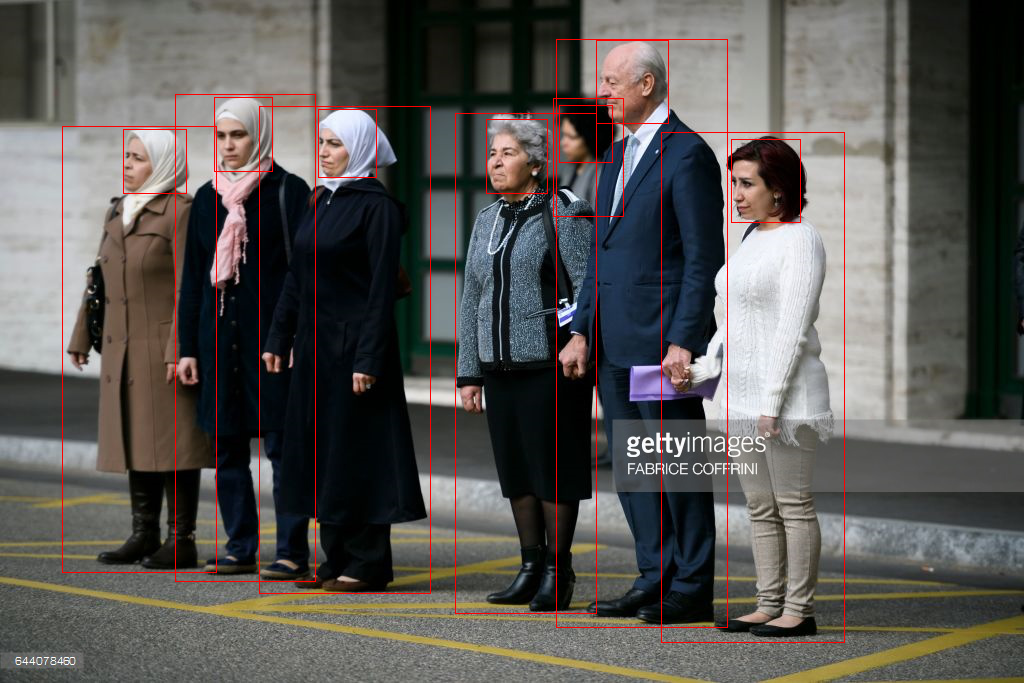

In [34]:
img